In [2]:
import numpy as np  # библиотека для матриц и математики
import pandas as pd  # библиотека для работы с табличками

import scipy.stats as sts  # модуль для работы со статистикой

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

#библиотеки для мо
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import plotly.express as px

In [3]:
# Данные по 2019 году для анализа
url_2019 = 'https://raw.githubusercontent.com/gulshatkd/Python-project-Hotel-Reservations/main/hotel_revenue_historical_2019.csv'

# Данные по 2020 году для гипотез
url_2020 = 'https://raw.githubusercontent.com/gulshatkd/Python-project-Hotel-Reservations/main/hotel_revenue_historical_full_2020.csv'

# Выводим данные по 2019 году
df = pd.read_csv(url_2019)

# Данные по 2020 году (нужны для гипотез)
df_2020 = pd.read_csv(url_2020)

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,1,20,2019,January,1,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,119.0,0,0,Canceled,12/22/2018
1,Resort Hotel,1,76,2019,January,1,1,1,2,2,...,No Deposit,240.0,NaN,0,Transient,57.9,0,1,Canceled,12/20/2018
2,Resort Hotel,1,113,2019,January,1,2,0,1,2,...,Non Refund,305.0,NaN,0,Transient,72.0,0,0,Canceled,11/16/2018
3,Resort Hotel,1,113,2019,January,1,2,0,1,2,...,Non Refund,305.0,NaN,0,Transient,72.0,0,0,Canceled,11/16/2018
4,Resort Hotel,1,113,2019,January,1,2,0,1,2,...,Non Refund,305.0,NaN,0,Transient,72.0,0,0,Canceled,11/16/2018


# Шаг 1 и 2. Выбор темы и сбор данных

Для нашего проекта мы взяли тему: исследование процесса бронирования отелей на основе готовой базы данных, взятой по ссылке: https://www.kaggle.com/datasets/mashkuratualhassan/hotel-dataset.

В ходе работы мы будем анализировать даты заезда, цены на номера, типы номеров, количество отмены и другую информацию, которая описана ниже. Постараемся построить различные диаграммы, проверить гипотезы, обучить модели для прогноза отмены бронирования.

# Шаг 3: Предварительная обработка

In [4]:
df.shape # смотрим на размерность данных (кол-во строк, кол-во столбцов)

(79264, 32)

In [5]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

## Описание данных


1) Индекс.

2) Тип отеля (city hotel, resort hotel).

3) is_canceled - 1-бронирование отменилось, 0-бронирование не отменилось.

4) lead_time - кол-во дней между датой бронирования и датой прибытия.

5) arrival_date_year - год заезда.

6) arrival_date_month - месяц заезда.

7) arrival_date_week_number - неделя заезда.

8) arrival_date_day_of_month - день заезда.

9) stays_in_weekend_nights - количество ночей, проведенных гостем в отеле, во время выходных.

10) stays_in_week_nights - количество ночей, проведенных гостем в отеле, в будние дни.

11) adults - количество взрослых.

12) children - количество детей.

13) babies - количество младенцев.

14) meal - тип завтрака: SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner)

15) country -страна происхождения.

16) market_segment  - тип бронирования: undefined, direct, groups, corporate, aviation, offline TA/TO - туристические агенты и операторы, online TA, complementary.

17) distribution_channel - канал осуществления операций.

18) is_repeated_guest - 1 - гость приехал повторно, 0 - гость впервые.

19) previous_cancellations - количество предыдущих бронирований, отмененных клиентом до текущего бронирования.

20) previous_bookings_not_canceled - количество предыдущих бронирований, не отмененных клиентом до текущего бронирования.

21) reserved_room_type - тип забронированного номера.

22) assigned_room_type - код типа номера, присвоенного бронированию. Иногда присвоенный тип номера отличается от забронированного типа по причинам, связанным с работой отеля (например, из-за перебронирования) или по желанию клиента.

23) booking_changes - кол-во изменений в бронировании.

24) deposit_type - внес ли клиент депозит для гарантии бронирования. No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.

25) agent - идентификатор туристического агентства, оформившего бронирование

26) company - идентификатор компании/организации, оформившей бронирование или ответственной за оплату бронирования.

27) days_in_waiting_list - кол-во дней, в течение которых бронирование находилось в списке ожидания, прежде чем оно было подтверждено клиенту.

28) customer_type - тип бронирования.

29) adr - средняя цена одной ночи в номере, определяемая путем деления суммы всех транзакций по размещению на общее количество ночей проживания.

30) required_car_parking_spaces - необходимое количество мест для парковки.

31) total_of_special_requests - количество особых просьб клиента (например, две односпальные кровати или верхний этаж).

32) reservation_status - статус бронирования. Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why

33) reservation_status_date - дата, когда был установлен последний статус. Эту переменную можно использовать в сочетании с ReservationStatus, чтобы понять, когда было отменено бронирование или когда клиент выписался из отеля.

In [6]:
# вывод количества пропусков в каждом столбце
df.isnull().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                             409
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             10792
company                           74754


Мы видим, что присутсвуют пропуски в столбцах children, country, agent, company.

Строки с пропусками в столбце country мы заменим на 'Unknown'.

Agent - если агентство не указано, скорее всего, бронирование было сделано без него, заменим на 0. То же самое с company и children.



In [7]:
df['country'] = df['country'].fillna('Unknown')
df[['agent', 'company', 'children']] = df[['agent', 'company', 'children']].fillna('0')

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,1,20,2019,January,1,1,0,2,2,...,No Deposit,240.0,0,0,Transient,119.0,0,0,Canceled,12/22/2018
1,Resort Hotel,1,76,2019,January,1,1,1,2,2,...,No Deposit,240.0,0,0,Transient,57.9,0,1,Canceled,12/20/2018
2,Resort Hotel,1,113,2019,January,1,2,0,1,2,...,Non Refund,305.0,0,0,Transient,72.0,0,0,Canceled,11/16/2018
3,Resort Hotel,1,113,2019,January,1,2,0,1,2,...,Non Refund,305.0,0,0,Transient,72.0,0,0,Canceled,11/16/2018
4,Resort Hotel,1,113,2019,January,1,2,0,1,2,...,Non Refund,305.0,0,0,Transient,72.0,0,0,Canceled,11/16/2018


In [8]:
# проверим выполнение
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79264 entries, 0 to 79263
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           79264 non-null  object 
 1   is_canceled                     79264 non-null  int64  
 2   lead_time                       79264 non-null  int64  
 3   arrival_date_year               79264 non-null  int64  
 4   arrival_date_month              79264 non-null  object 
 5   arrival_date_week_number        79264 non-null  int64  
 6   arrival_date_day_of_month       79264 non-null  int64  
 7   stays_in_weekend_nights         79264 non-null  int64  
 8   stays_in_week_nights            79264 non-null  int64  
 9   adults                          79264 non-null  int64  
 10  children                        79264 non-null  object 
 11  babies                          79264 non-null  int64  
 12  meal                            

In [10]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,79264.000000,79264.000000,79264.0,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000,79264.000000
mean,0.365260,101.063459,2019.0,31.485378,15.813093,0.903474,2.450583,1.845630,0.008705,0.030531,0.125139,0.118818,0.210915,3.375467,95.000002,0.065982,0.516275
std,0.481506,105.946772,0.0,13.429799,8.738979,0.991648,1.879098,0.616085,0.104525,0.172044,1.025689,1.333111,0.634315,21.278640,48.273647,0.249165,0.757528
min,0.000000,0.000000,2019.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,2019.0,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,0.000000,0.000000
50%,0.000000,65.000000,2019.0,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,0.000000,0.000000
75%,1.000000,157.000000,2019.0,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,117.000000,0.000000,1.000000
max,1.000000,737.000000,2019.0,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,1.000000,26.000000,58.000000,21.000000,391.000000,5400.000000,3.000000,5.000000


In [11]:
df.shape

(79264, 32)

In [12]:
df['meal'].unique()

array(['BB', 'HB', 'Undefined', 'FB', 'SC'], dtype=object)

In [13]:
# Undefined - это то же самое, что и SC, сделаем замену

df["meal"].replace("Undefined", "SC", inplace=True)

In [14]:
# Нужно проверить, нет ли бронирований без гостей

df_filter = df.loc[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)]
df_filter

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
298,Resort Hotel,1,0,2019,February,8,15,0,0,0,...,No Deposit,0,383.0,0,Transient,0.0,0,0,Canceled,2/15/2019
4223,Resort Hotel,1,0,2019,November,48,21,0,0,0,...,No Deposit,0,386.0,0,Group,0.0,0,0,Canceled,11/21/2019
6677,City Hotel,1,173,2019,April,15,8,2,3,0,...,No Deposit,21.0,0,0,Transient-Party,0.0,0,0,Canceled,3/29/2019
10713,City Hotel,1,244,2019,July,28,6,2,4,0,...,No Deposit,19.0,0,0,Transient,0.0,0,0,Canceled,2/23/2019
10723,City Hotel,1,244,2019,July,28,6,2,4,0,...,No Deposit,19.0,0,0,Transient,0.0,0,0,Canceled,2/23/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78236,City Hotel,0,0,2019,December,52,24,0,0,0,...,No Deposit,28.0,0,0,Transient,0.0,0,0,Check-Out,12/24/2019
78237,City Hotel,0,0,2019,December,52,24,0,0,0,...,No Deposit,28.0,0,0,Transient,0.0,0,1,Check-Out,12/24/2019
78238,City Hotel,0,0,2019,December,52,24,0,0,0,...,No Deposit,28.0,0,0,Contract,0.0,0,0,Check-Out,12/24/2019
78239,City Hotel,0,0,2019,December,52,24,0,0,0,...,No Deposit,28.0,0,0,Transient,0.0,0,0,Check-Out,12/24/2019


In [15]:
# Удалим такие бронирования

df = df.drop(df.loc[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)].index)

Для сравнения данных по отдельным типам отелей создадим отдельные датасеты для Resort hotel и  City Hotel

In [16]:
# создание таблицы только с отелями типа resort
df_resort_all = df[df['hotel'] == 'Resort Hotel']

# Колонка с типом отеля больше не нужна, удалим
df_resort_all = df_resort_all.drop(['hotel'], axis=1)
df_resort_all.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,20,2019,January,1,1,0,2,2,2.0,...,No Deposit,240.0,0,0,Transient,119.0,0,0,Canceled,12/22/2018
1,1,76,2019,January,1,1,1,2,2,0.0,...,No Deposit,240.0,0,0,Transient,57.9,0,1,Canceled,12/20/2018
2,1,113,2019,January,1,2,0,1,2,0.0,...,Non Refund,305.0,0,0,Transient,72.0,0,0,Canceled,11/16/2018
3,1,113,2019,January,1,2,0,1,2,0.0,...,Non Refund,305.0,0,0,Transient,72.0,0,0,Canceled,11/16/2018
4,1,113,2019,January,1,2,0,1,2,0.0,...,Non Refund,305.0,0,0,Transient,72.0,0,0,Canceled,11/16/2018


In [17]:
# создание таблицы только с отелями типа city
df_city_all =  df[df['hotel'] == 'City Hotel']

# Колонка с типом отеля больше не нужна, удалим
df_city_all = df_city_all.drop(['hotel'], axis=1)
df_city_all.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
4817,1,119,2019,January,1,1,0,1,2,0.0,...,No Deposit,14.0,0,0,Transient,74.25,0,0,Canceled,12/31/2018
4818,1,25,2019,January,1,1,2,2,2,2.0,...,No Deposit,9.0,0,0,Transient,178.25,0,0,Canceled,12/7/2018
4819,1,150,2019,January,1,2,2,1,2,0.0,...,Non Refund,21.0,0,91,Transient,101.00,0,0,Canceled,11/4/2018
4820,1,150,2019,January,1,2,2,1,2,0.0,...,Non Refund,21.0,0,91,Transient,101.00,0,0,Canceled,11/4/2018
4821,1,150,2019,January,1,2,2,1,2,0.0,...,Non Refund,21.0,0,91,Transient,101.00,0,0,Canceled,11/4/2018


Для дальнейшего анализа мы будем использовать именно данные с неотмененными бронированиями (с некоторыми исключениями), так как отмененные бронирования не имеют ценности в контексте анализа актуальных данных.

In [18]:
# Выделяю из датасетов df_resort_all и df_city_all только неотмененные бронирования

df_resort = df_resort_all[df_resort_all['is_canceled'] == 0]
df_city = df_city_all[df_city_all['is_canceled'] == 0]

__Теперь всё то же самое для 2020 года__

In [19]:
# Данные по 2020 году (нужны для гипотез)
df_2020 = pd.read_csv(url_2020)
df_2020.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,1,74,2020,January,1,1,1,0,2,...,No Deposit,5.0,NaN,0,Transient,57.60,0,0,Canceled,10/20/2019
1,Resort Hotel,1,62,2020,January,1,1,2,2,2,...,No Deposit,240.0,NaN,0,Transient,51.50,0,1,Canceled,12/4/2019
2,Resort Hotel,1,62,2020,January,1,1,2,2,2,...,No Deposit,240.0,NaN,0,Transient,51.50,0,1,Canceled,11/11/2019
3,Resort Hotel,1,62,2020,January,1,1,2,2,2,...,No Deposit,240.0,NaN,0,Transient,51.50,0,1,Canceled,12/4/2019
4,Resort Hotel,1,71,2020,January,1,1,2,2,1,...,No Deposit,241.0,NaN,0,Transient,32.22,0,1,Canceled,10/29/2019


In [20]:
unique_months = df_2020['arrival_date_month'].unique()
print(unique_months)

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


Значит при проверке гипотез будем сравнивать только периоды с января по август

In [21]:
# вывод количества пропусков в каждом столбце
df_2020.isnull().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                              83
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              5664
company                           38377


In [22]:
df_2020['country'] = df_2020['country'].fillna('Unknown')
df_2020[['agent', 'company', 'children']] = df_2020[['agent', 'company', 'children']].fillna('0')

df_2020.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,1,74,2020,January,1,1,1,0,2,...,No Deposit,5.0,0,0,Transient,57.60,0,0,Canceled,10/20/2019
1,Resort Hotel,1,62,2020,January,1,1,2,2,2,...,No Deposit,240.0,0,0,Transient,51.50,0,1,Canceled,12/4/2019
2,Resort Hotel,1,62,2020,January,1,1,2,2,2,...,No Deposit,240.0,0,0,Transient,51.50,0,1,Canceled,11/11/2019
3,Resort Hotel,1,62,2020,January,1,1,2,2,2,...,No Deposit,240.0,0,0,Transient,51.50,0,1,Canceled,12/4/2019
4,Resort Hotel,1,71,2020,January,1,1,2,2,1,...,No Deposit,241.0,0,0,Transient,32.22,0,1,Canceled,10/29/2019


In [23]:
df_2020.shape

(40687, 32)

In [24]:
# Undefined - это то же самое, что и SC, сделаем замену
df_2020["meal"].replace("Undefined", "SC", inplace=True)

In [25]:
# Нужно проверить, нет ли бронирований без гостей

df_2020_filter = df_2020.loc[(df['adults'] == 0) & (df_2020['children'] == 0) & (df_2020['babies'] == 0)]
df_2020_filter

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
4899,City Hotel,1,45,2020,January,4,26,1,3,2,...,No Deposit,83.0,0,0,Transient,84.80,0,0,Canceled,12/13/2019
4921,City Hotel,1,43,2020,January,4,27,2,2,2,...,No Deposit,9.0,0,0,Transient,74.80,0,2,Canceled,12/27/2019
5076,City Hotel,1,573,2020,February,5,2,0,2,2,...,Non Refund,1.0,0,0,Transient,62.00,0,0,Canceled,10/21/2018
5401,City Hotel,1,35,2020,February,7,13,2,5,3,...,No Deposit,9.0,0,0,Transient,116.72,0,1,Canceled,2/7/2020
5556,City Hotel,1,65,2020,February,7,17,1,2,2,...,No Deposit,9.0,0,0,Transient,79.20,0,2,Canceled,1/20/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36460,City Hotel,0,10,2020,July,27,6,0,1,1,...,No Deposit,219.0,0,0,Transient-Party,95.00,0,0,Check-Out,7/7/2020
36861,City Hotel,0,25,2020,July,28,10,1,2,2,...,No Deposit,9.0,0,0,Transient,146.67,0,2,Check-Out,7/13/2020
38411,City Hotel,0,5,2020,August,31,3,0,1,2,...,No Deposit,0,0,0,Transient,159.75,0,0,Check-Out,8/4/2020
39157,City Hotel,0,166,2020,August,32,12,2,2,2,...,No Deposit,14.0,0,0,Transient-Party,146.25,0,0,Check-Out,8/16/2020


In [26]:
# Удалим такие бронирования

df_2020 = df_2020.drop(df_2020.loc[(df_2020['adults'] == 0) & (df_2020['children'] == 0) & (df_2020['babies'] == 0)].index)

In [27]:
# создание таблицы только с отелями типа resort
df_2020_resort_all = df_2020[df_2020['hotel'] == 'Resort Hotel']

# Колонка с типом отеля больше не нужна, удалим
df_2020_resort_all = df_2020_resort_all.drop(['hotel'], axis=1)
df_2020_resort_all.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,74,2020,January,1,1,1,0,2,0,...,No Deposit,5.0,0,0,Transient,57.60,0,0,Canceled,10/20/2019
1,1,62,2020,January,1,1,2,2,2,0,...,No Deposit,240.0,0,0,Transient,51.50,0,1,Canceled,12/4/2019
2,1,62,2020,January,1,1,2,2,2,0,...,No Deposit,240.0,0,0,Transient,51.50,0,1,Canceled,11/11/2019
3,1,62,2020,January,1,1,2,2,2,0,...,No Deposit,240.0,0,0,Transient,51.50,0,1,Canceled,12/4/2019
4,1,71,2020,January,1,1,2,2,1,0,...,No Deposit,241.0,0,0,Transient,32.22,0,1,Canceled,10/29/2019


In [28]:
# создание таблицы только с отелями типа city
df_2020_city_all =  df_2020[df_2020['hotel'] == 'City Hotel']

# Колонка с типом отеля больше не нужна, удалим
df_2020_city_all = df_2020_city_all.drop(['hotel'], axis=1)
df_2020_city_all.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
3945,1,26,2020,January,1,1,1,0,1,0,...,No Deposit,9.0,0,0,Transient,128.0,0,2,Canceled,12/17/2019
3946,1,70,2020,January,1,1,1,0,2,0,...,No Deposit,9.0,0,0,Transient,131.4,0,1,Canceled,10/24/2019
3947,1,187,2020,January,1,1,1,0,2,0,...,No Deposit,9.0,0,0,Transient,137.7,0,3,Canceled,11/19/2019
3948,1,187,2020,January,1,1,1,0,2,0,...,No Deposit,9.0,0,0,Transient,137.7,0,3,Canceled,11/19/2019
3949,1,46,2020,January,1,1,2,0,2,0,...,No Deposit,0,0,0,Transient-Party,65.0,0,0,Canceled,12/21/2019


In [29]:
# Выделяю из датасетов df_resort_all и df_city_all только неотмененные бронирования

df_2020_resort = df_2020_resort_all[df_2020_resort_all['is_canceled'] == 0]
df_2020_city = df_2020_city_all[df_2020_city_all['is_canceled'] == 0]

# Перед шагом визуализации поработаем с выбросами

# lead_time

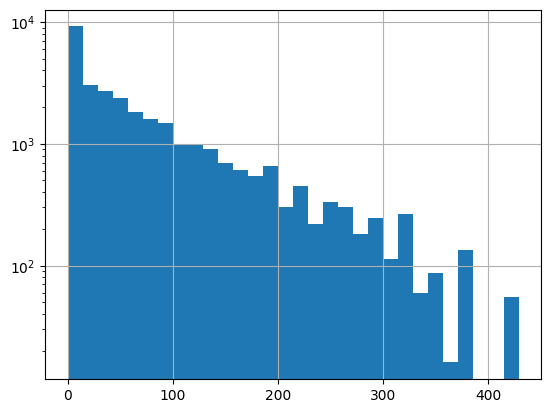

In [30]:
df_city['lead_time'].hist(bins=30, log=True);

По данному графику видно, что присутсвуют аномальные значения, которые искажают анализ - выбросы.
Для того, чтобы стабилизировать ситуацию, мы решили поработать с выбросами через квантили, для этого мы вычисляем значения первого квартиля (Q1) и третьего квартиля (Q3) для столбца 'lead_time' в датафрейме df_city, далее определяя межквартильный размах. Удаляем выбросы из исходного датафрейма df_city, фильтруя его по условию, что значения столбца 'lead_time' находятся в диапазоне от lower_threshold до upper_threshold.

In [31]:
# Оценка выбросов
Q1 = df_city['lead_time'].quantile(0.25)
Q3 = df_city['lead_time'].quantile(0.75)
IQR = Q3 - Q1

lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

outliers = df_city[(df_city['lead_time'] < lower_threshold) | (df_city['lead_time'] > upper_threshold)]

# Обработка выбросов
# Удалим выбросы из датасета
df_city = df_city[(df_city['lead_time'] >= lower_threshold) & (df_city['lead_time'] <= upper_threshold)]

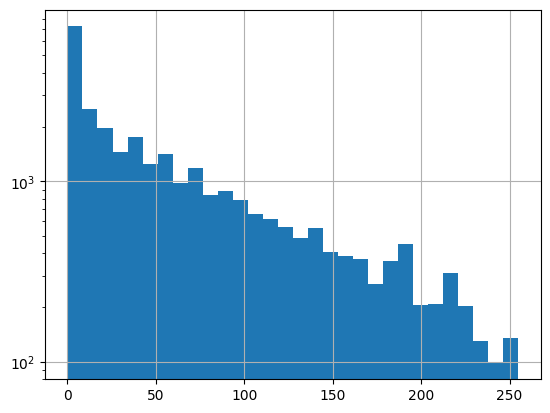

In [32]:
df_city['lead_time'].hist(bins=30, log=True);

То же самое проделываем для отелей типа resort.

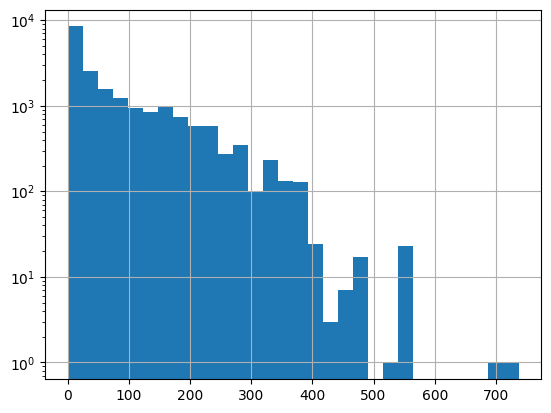

In [33]:
df_resort['lead_time'].hist(bins=30, log=True);

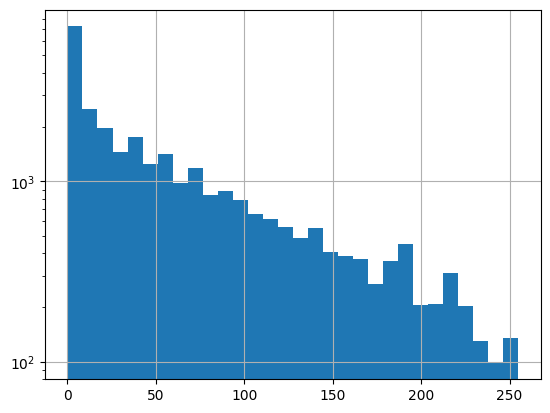

In [34]:
# Оценка выбросов
Q11 = df_resort['lead_time'].quantile(0.25)
Q33 = df_resort['lead_time'].quantile(0.75)
IQR1 = Q33 - Q11

lower_threshold = Q11 - 1.5 * IQR1
upper_threshold = Q33 + 1.5 * IQR1

outlierss = df_resort[(df_resort['lead_time'] < lower_threshold) | (df_resort['lead_time'] > upper_threshold)]

# Обработка выбросов
# Удалим выбросы из датасета
df_resort = df_resort[(df_resort['lead_time'] >= lower_threshold) & (df_resort['lead_time'] <= upper_threshold)]

df_city['lead_time'].hist(bins=30, log=True);

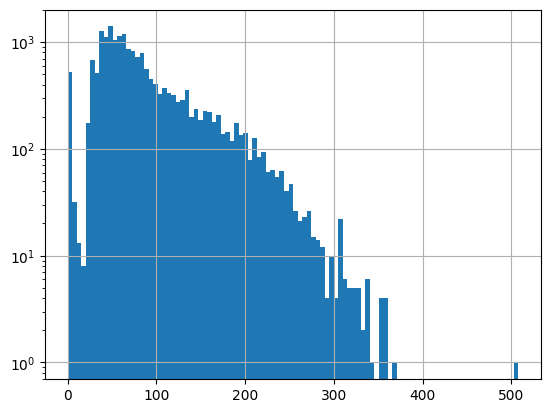

In [35]:
# построим столбчатую диаграмму сколько платят за ночь, чтобы оценить выброс
df_resort['adr'].hist(log=True, bins=100);

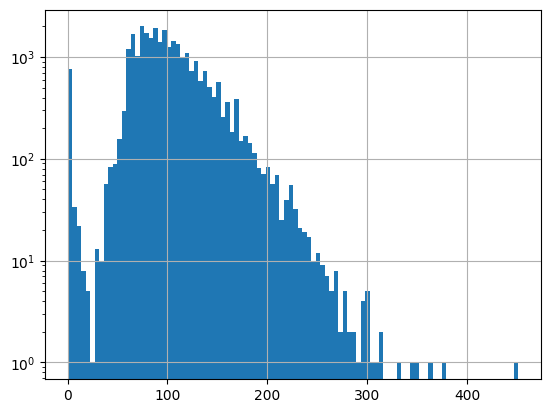

In [36]:
df_city['adr'].hist(log=True, bins=100);

In [37]:
# Получение столбца adr для каждого типа отеля
adr_resort = df_resort['adr']
adr_city = df_city['adr']

# Составление таблицы значений по возрастанию и фильтрация значений меньше 1000
table_resort = adr_resort.sort_values().loc[adr_resort <= 400].reset_index(drop=True)
table_city = adr_city.sort_values().loc[adr_city <= 1000].reset_index(drop=True)

print("Resort ADR:")
print(table_resort)

print("\nCity ADR:")
print(table_city)

Resort ADR:
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
19192    357.0
19193    357.0
19194    359.0
19195    359.0
19196    367.0
Name: adr, Length: 19197, dtype: float64

City ADR:
0          0.00
1          0.00
2          0.00
3          0.00
4          0.00
          ...  
28762    345.00
28763    349.63
28764    365.00
28765    375.50
28766    451.50
Name: adr, Length: 28767, dtype: float64


# Шаг 4. Визуализация

Главные вопросы:
- процентное распределение по странам
- сколько гости платят за ночь
- как менялась цена за ночь в течение года
- какой месяц был самым загруженным
- процентное распределение рыночного сегмента
- сколько было отмен бронирования
- распределение количества отмен бронирования в течение года



При создании круговой диаграммы с количеством посетителей по странам в процентном соотношении, мы удалили все страны, которые составляли менее 1%. Поскольку они не несли смысловой нагрузки.

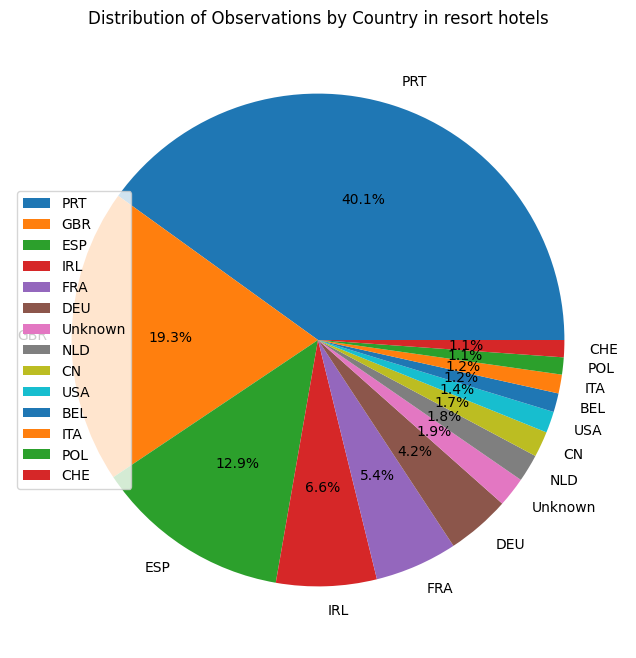

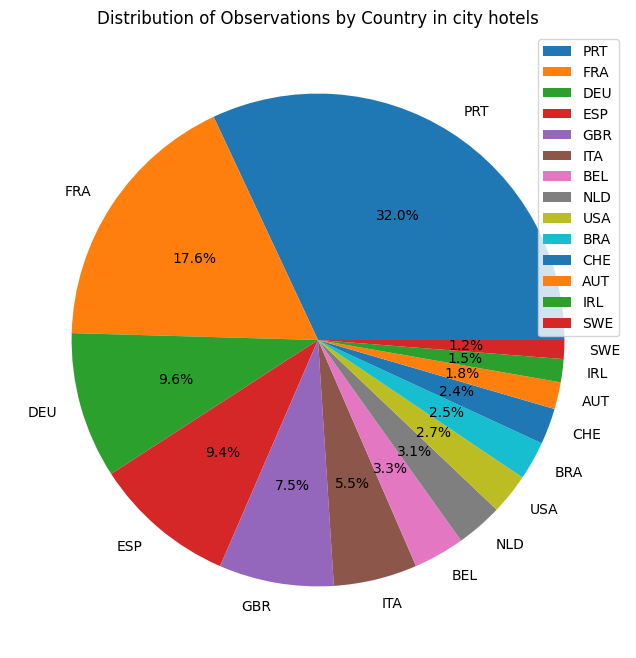

In [38]:
# Подсчет количества наблюдений для каждой страны в df_resort
country_counts_resort = df_resort['country'].value_counts()

# Вычисление процентного соотношения для каждой страны в df_resort
country_percentages_resort = country_counts_resort / country_counts_resort.sum() * 100

# Фильтрация значений, составляющих менее 1% от общего количества наблюдений в df_resort
filtered_countries_resort = country_percentages_resort[country_percentages_resort >= 1]

# Сортировка стран по убыванию в df_resort
sorted_countries_resort = filtered_countries_resort.sort_values(ascending=False)

# Подсчет количества наблюдений для каждой страны в df_city
country_counts_city = df_city['country'].value_counts()

# Вычисление процентного соотношения для каждой страны в df_city
country_percentages_city = country_counts_city / country_counts_city.sum() * 100

# Фильтрация значений, составляющих менее 1% от общего количества наблюдений в df_city
filtered_countries_city = country_percentages_city[country_percentages_city >= 1]

# Сортировка стран по убыванию в df_city
sorted_countries_city = filtered_countries_city.sort_values(ascending=False)

# Создание первой круговой диаграммы для df_resort
plt.figure(figsize=(8, 8))
plt.pie(sorted_countries_resort, labels=sorted_countries_resort.index, autopct='%.1f%%')
plt.title('Distribution of Observations by Country in resort hotels')
plt.legend(sorted_countries_resort.index, loc='center left')
plt.show()

# Создание второй круговой диаграммы для df_city
plt.figure(figsize=(8, 8))
plt.pie(sorted_countries_city, labels=sorted_countries_city.index, autopct='%.1f%%')
plt.title('Distribution of Observations by Country in city hotels')
plt.legend(sorted_countries_city.index, loc='best')
plt.show()

На круговых диаграммах представленных выше, в легенде страны расположены в порядке убывания.


В топ-5 стран также входят страны типа отеля resort: Великобритания, Испания, Ирландия, Франция. Менее 2% от обшего числа посетитилей составляют жители Нидерланд, США, Бельгии, Италии и Польши.

Говоря об отелях типа city, то в топ также входят Франция, Германия, Испания, Великобритания, Италия. Менее 2% составляют лишь три страны: Австрия, Ирландия, Швеция.

Смотря на пересечение выводов, можно заметить, что наиболее активные туристы, чья доля составляет более 10% - это поргутгальцы (39% в resort отелях и 32% в city), занимая лидирующую позицию, французы (17.6% в city отелях), британцы (20.2% в resort отелях).

## Теперь оценим, сколько в среднем гости платят за ночь: adr.

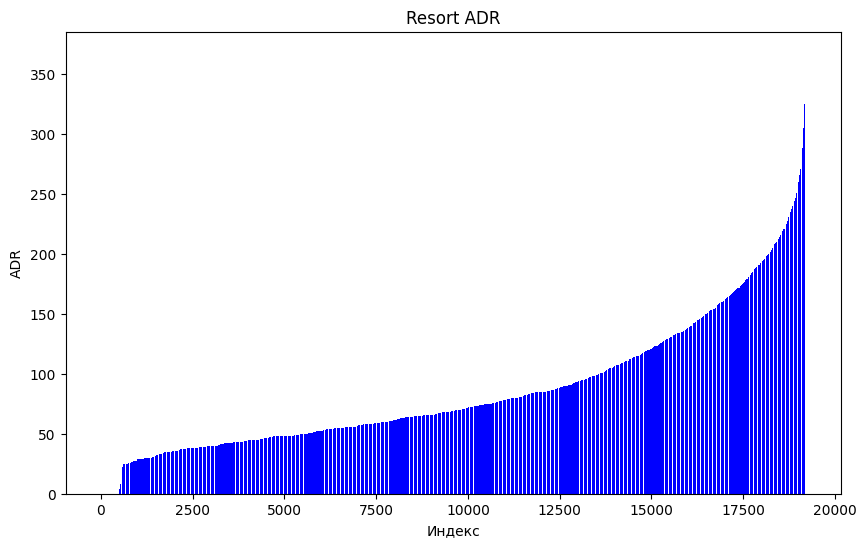

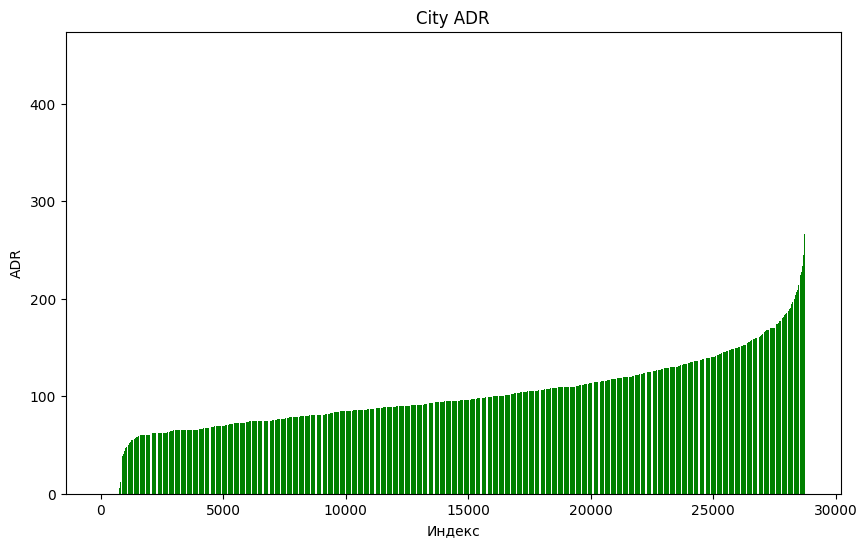

In [39]:
# Создание столбчатой диаграммы для данных из таблицы table_resort
plt.figure(figsize=(10, 6))  # Размер графика
plt.bar(range(len(table_resort)), table_resort, color='blue')
plt.xlabel('Индекс')
plt.ylabel('ADR')
plt.title('Resort ADR')
plt.show()

# Создание столбчатой диаграммы для данных из таблицы table_city
plt.figure(figsize=(10, 6))
plt.bar(range(len(table_city)), table_city, color='green')
plt.xlabel('Индекс')
plt.ylabel('ADR')
plt.title('City ADR')
plt.show()

In [40]:
# Получение максимальных значений
max_value = np.max(table_resort)
max_value2 = np.max(table_city)
print('Максимальная цена в resort отелях:', max_value)
print('Максимальная цена в city отелях:', max_value2)

Максимальная цена в resort отелях: 367.0
Максимальная цена в city отелях: 451.5


In [41]:
# Получение минимальных значений с исключением нулевых значений
min_value = np.min(table_resort[table_resort > 0])
min_value2 = np.min(table_city[table_city > 0])

print('Минимальная цена в resort отелях:', min_value)
print('Минимальная цена в city отелях:', min_value2)

Минимальная цена в resort отелях: 1.56
Минимальная цена в city отелях: 1.0


In [42]:
total_indexes = len(table_resort)
total_indexess = len(table_city)
print('Всего индексов:', total_indexes)
print('Всего индексов:', total_indexess)

Всего индексов: 19197
Всего индексов: 28767


Таким образом, мы видим, что максимальная цена в resort отелях за одну ночь сотсаляет 367, а в city - 451.5. Минимальная цена же за одну ночь колеблится у значения равного 1: 1 в city отелях, 1.56 в resort отелях.

При этом всего наблюдений в resort отелях - 19,197, а в city - 28,767.

Также давайте посмотрим на медиану, среднее значение и моду в таблицах table_resort, table_city.

In [43]:
# Нахождение медианы, среднего значения и моды для таблицы "table_resort"
median_resort = table_resort.median()
mean_resort = table_resort.mean()
mode_resort = table_resort.mode().values[0]

# Нахождение медианы, среднего значения и моды для таблицы "table_city"
median_city = table_city.median()
mean_city = table_city.mean()
mode_city = table_city.mode().values[0]

print('Медиана в таблице "table_resort":', median_resort)
print('Среднее значение в таблице "table_resort":', mean_resort)
print('Мода в таблице "table_resort":', mode_resort)

print('Медиана в таблице "table_city":', median_city)
print('Среднее значение в таблице "table_city":', mean_city)
print('Мода в таблице "table_city":', mode_city)

Медиана в таблице "table_resort": 69.0
Среднее значение в таблице "table_resort": 86.24716882846278
Мода в таблице "table_resort": 48.0
Медиана в таблице "table_city": 95.0
Среднее значение в таблице "table_city": 100.5115124969583
Мода в таблице "table_city": 65.0


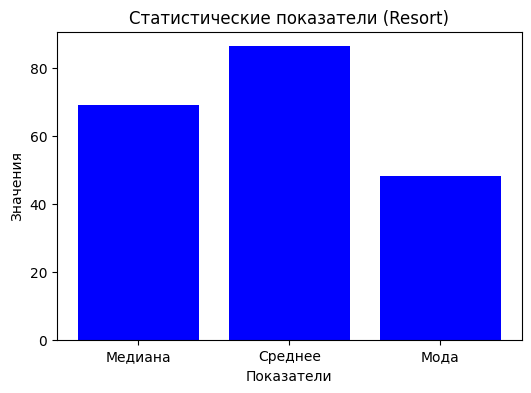

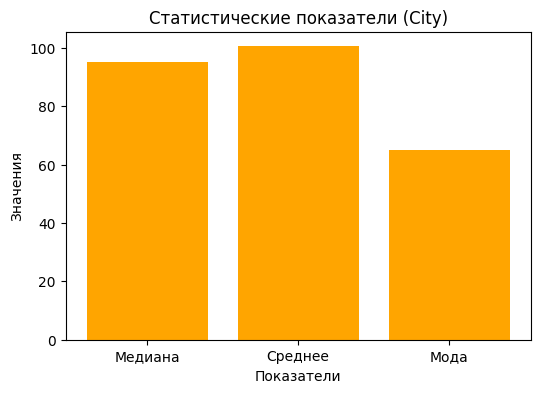

In [44]:
# Создание первого графика для "table_resort"
plt.figure(figsize=(6, 4))
plt.bar(['Медиана', 'Среднее', 'Мода'], [median_resort, mean_resort, mode_resort], color='blue')
plt.xlabel('Показатели')
plt.ylabel('Значения')
plt.title('Статистические показатели (Resort)')

plt.show()

# Создание второго графика для "table_city"
plt.figure(figsize=(6, 4))
plt.bar(['Медиана', 'Среднее', 'Мода'], [median_city, mean_city, mode_city], color='orange')
plt.xlabel('Показатели')
plt.ylabel('Значения')
plt.title('Статистические показатели (City)')

plt.show()

Здесь мы можем отметить, что все значения отелей типа city больше аналогчиных значений отелей типа resort.

## Оценим как менялась цена за ночь в течение года

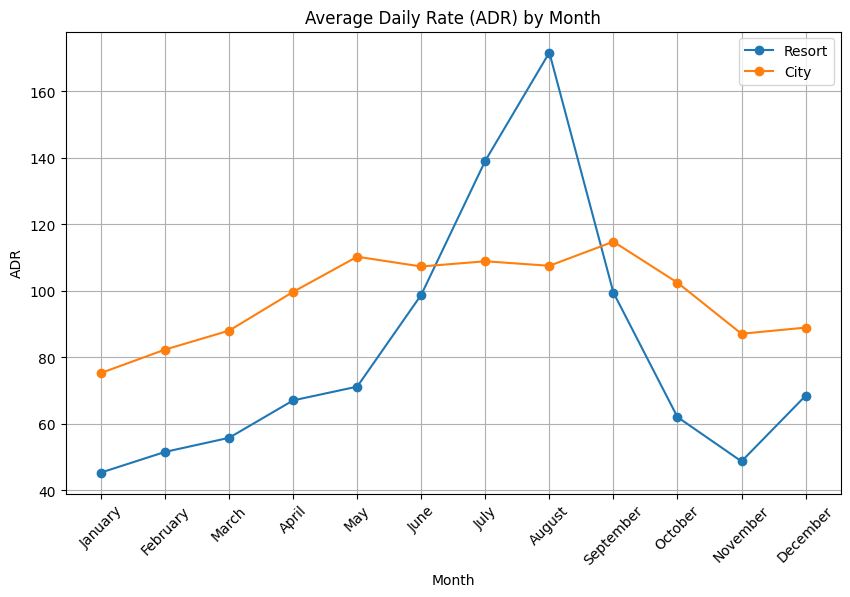

In [45]:
# Группировка данных по месяцу и вычисление среднего значения ADR для каждого типа отелей
grouped_data_resort = df_resort.groupby("arrival_date_month")["adr"].mean()
grouped_data_city = df_city.groupby("arrival_date_month")["adr"].mean()

# Создание линейных диаграмм для каждого типа отелей
plt.figure(figsize=(10, 6))

# Сортировка месяцев
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']
grouped_data_resort = grouped_data_resort.reindex(months_order)
grouped_data_city = grouped_data_city.reindex(months_order)

# Построение линейных диаграмм
plt.plot(grouped_data_resort.index, grouped_data_resort.values, marker="o", label="Resort")
plt.plot(grouped_data_city.index, grouped_data_city.values, marker="o", label="City")

plt.xlabel("Month")
plt.ylabel("ADR")
plt.title("Average Daily Rate (ADR) by Month")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Наибольшое значение ADR в рамках resort отелей принимает в августе, а в city - в сентябре. Можно ограничить временной промежуток с мая до сентября, аргументируя стабильностью роста цен и поддержанием их на наиболее высоком уровне за весь год. Что также подтверждает нашу гипотезу о сезонности заезда посетителей.

Помним, что наиболее заргуженный месяц - октябрь, однако ни в одном типе отелей не наблюдаетс пиковость значения цены за ночь. Более того, цена лишь начинала падать, совершая подъем лишь к декабрю, что можно связать с новогодними праздниками.

## Оценим market_segment

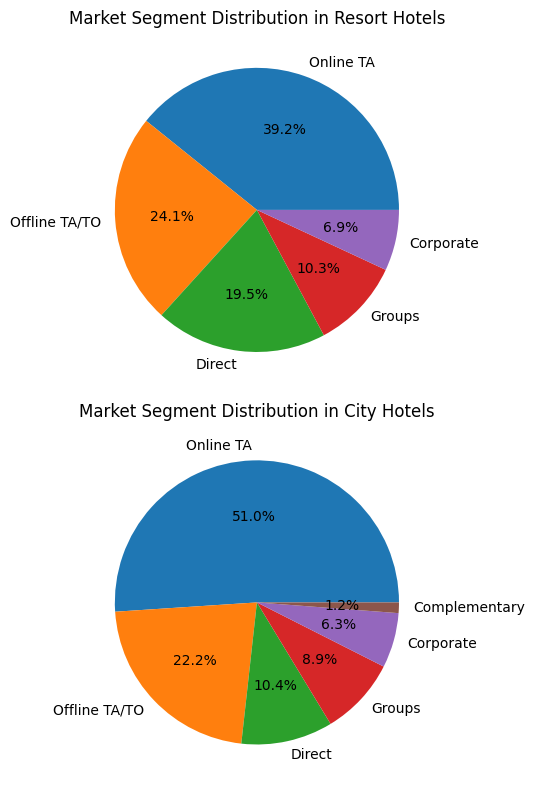

In [46]:
# Подсчет количества наблюдений для каждого маркетингового сегмента по типу отеля в df_resort
resort_segment_counts = df_resort["market_segment"].value_counts()
resort_segment_percentages = resort_segment_counts / resort_segment_counts.sum() * 100
filtered_resort_segments = resort_segment_percentages[resort_segment_percentages >= 1]

# Подсчет количества наблюдений для каждого маркетингового сегмента по типу отеля в df_city
city_segment_counts = df_city["market_segment"].value_counts()
city_segment_percentages = city_segment_counts / city_segment_counts.sum() * 100
filtered_city_segments = city_segment_percentages[city_segment_percentages >= 1]

# Создание круговой диаграммы для распределения маркетингового сегмента по типу отеля в df_resort
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.pie(filtered_resort_segments, labels=filtered_resort_segments.index, autopct='%.1f%%')
plt.title('Market Segment Distribution in Resort Hotels')

# Создание круговой диаграммы для распределения маркетингового сегмента по типу отеля в df_city
plt.subplot(2, 1, 2)
plt.pie(filtered_city_segments, labels=filtered_city_segments.index, autopct='%.1f%%')
plt.title('Market Segment Distribution in City Hotels')

plt.tight_layout()
plt.show()

Очевидным становится то, что большая часть организации сбыта товара происходит через интернет пространства: 39.2% для resort отелей и 51% - для city.

Далее в обоих типах отелей распредление рыночного сегмента просиходит практически идентично, учитывая, что мы изначально не брали в расчет сегменты, которые составляют менее 1%. Последовательность выглядит так: offline TA/TO, Direct, Groups, Corporate. В city отелях сегмент Complementary занимет 1.2%, а в resort отелях менее 1%.

##Составим ящики с усами для визуальзации зависимостей разных перемнных

Мы это делаем с целью отображения распределения значений и основных статистических параметров, таких как медиана, квартили, выбросы и интерквартильный размах. Также для отображения распределения значений и основных статистических параметров, таких как медиана, квартили, выбросы и интерквартильный размах.

- средняя линия отвечает за медианное значение (50-й перцентиль) - значение, разделяющее данные на две равные части;
- нижняя полоска отображает первый квартиль (25-й перцентиль). То есть нижняя граница ящика представляет значение, ниже которого находится 25% данных;
- верхняя полоска ящика отображает третий квартиль (75-й перцентиль), что означает, что 75% данных находятся ниже этого значения.

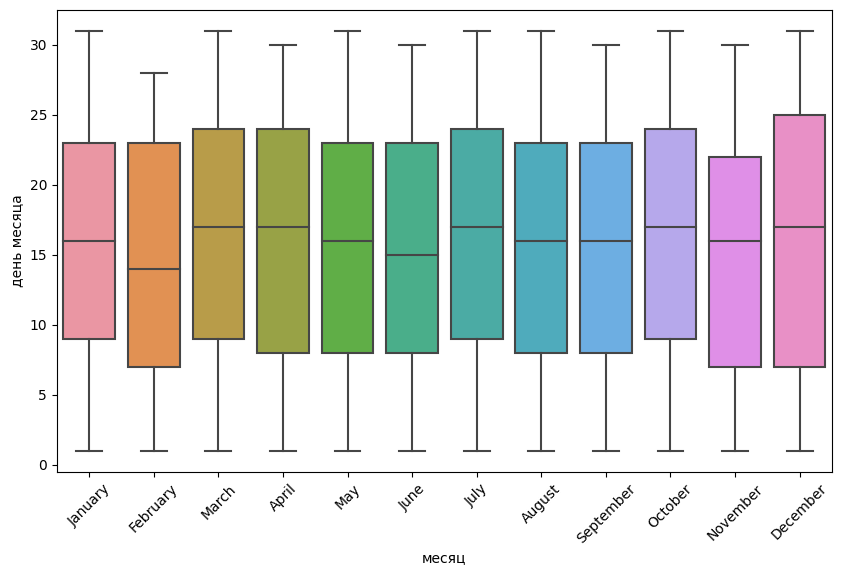

In [47]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='arrival_date_month',
            y='arrival_date_day_of_month',
            data=df_resort)

plt.xlabel('месяц')
plt.ylabel('день месяца')
plt.xticks(rotation=45)

plt.show()

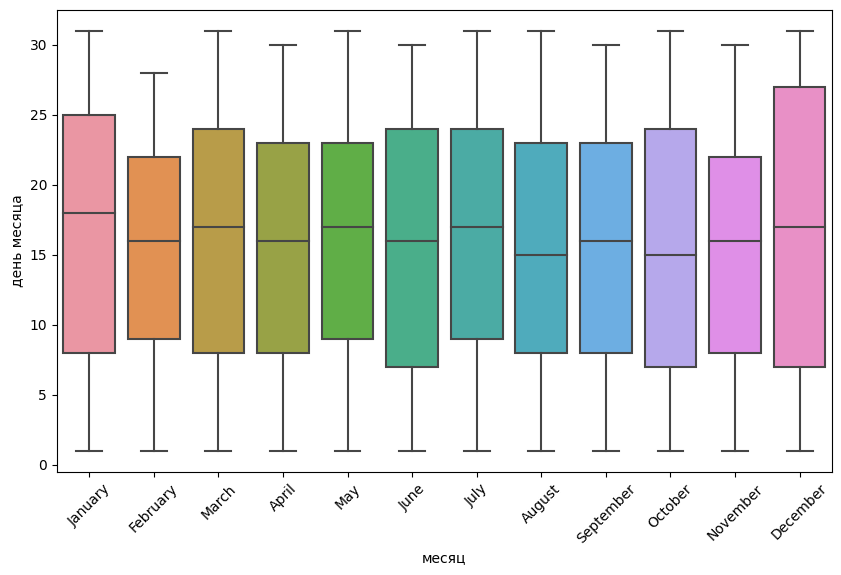

In [48]:
plt.figure(figsize=(10, 6))

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']

sns.boxplot(x='arrival_date_month',
            y='arrival_date_day_of_month',
            data=df_city,
            order=month_order)

plt.xlabel('месяц')
plt.ylabel('день месяца')
plt.xticks(rotation=45)

plt.show()

На этих двух графиках с усами, мы видим наибольший размах интерквартильных промежутков в декабре. Если в resort отелях это слабое превосходство, то в city отелях оно довольно большое.

В resort отелях медиана находится на примерно одинаковом уровне в марте, апреле, июле, октябре и декабре. В city отелях наибольшая медиана сразу выделяется в январе, превышая другие аналогичные значения.

Text(0, 0.5, 'средняя цена за ночь')

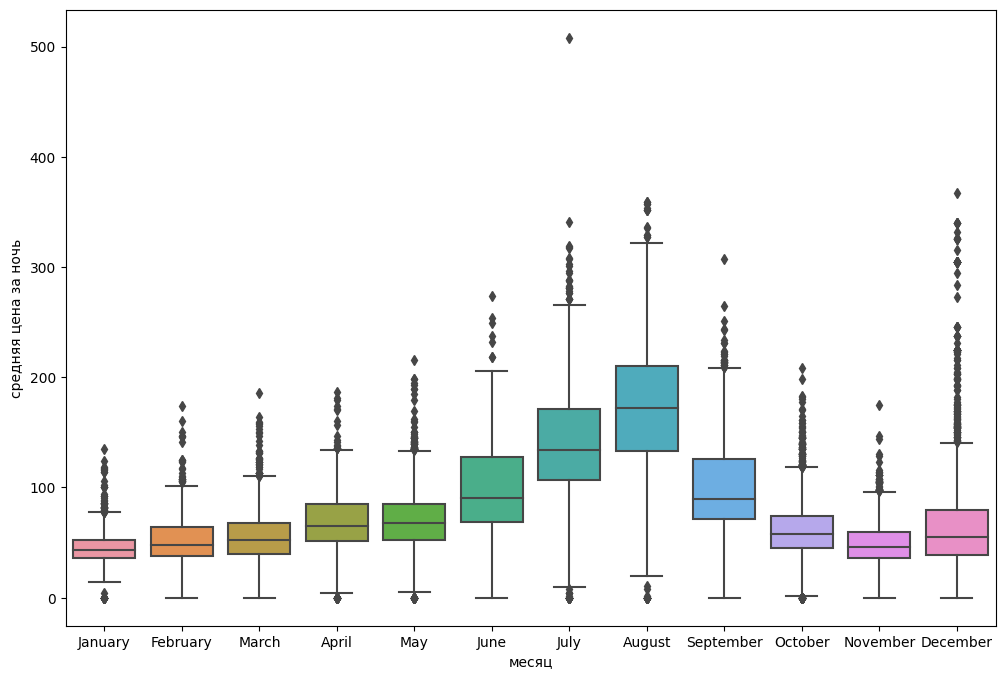

In [49]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='arrival_date_month',
            y='adr',
            data=df_resort)

plt.xlabel('месяц')
plt.ylabel('средняя цена за ночь')

Text(0, 0.5, 'средняя цена за ночь')

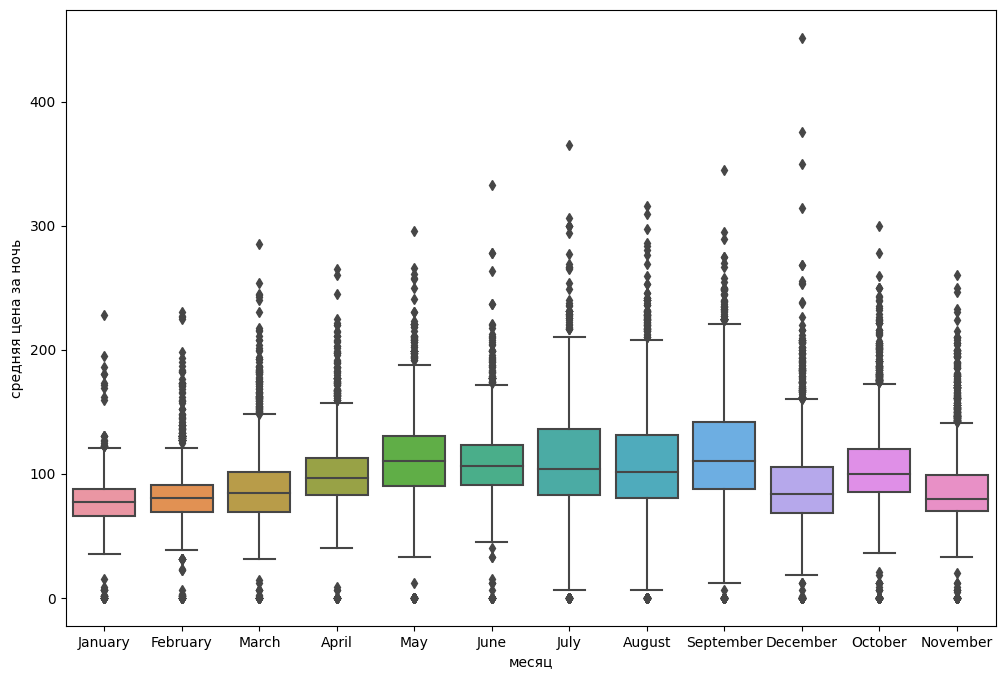

In [50]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='arrival_date_month',
            y='adr',
            data=df_city)

plt.xlabel('месяц')
plt.ylabel('средняя цена за ночь')

Последние два графика с ящиками с усами также подтверждают, что между переменнами цена за ночь (ADR) и месяцем присутсвует положительная связь, поскольку в наиболее загруженный сезон наблюдается повышение цен.

Однако мы наблюдаем небольшую размерность прямоугольников, что может говорить о том, что большинство значений данных сосредоточены в узком диапазоне. Это же, в свою очередь, может происходить в случае, если данные имеют однородное распределение внутри месяцев или групп. Или если данные имеют ограниченный диапазон значений. Также это может быть, если данные имеют малую разницу между минимальными и максимальными значениями. Что в принципе можно считать справедливым для нашего датасета, в определенной мере.

На данных круговых диаграммах мы видим процентное соотношение количества отмен и подтвержденных бронирований в обоих типах отелей.

И в resort, и в ciry отелях количество отмен меньше количества подтверждений: в resort - 72.4% к 27.6%, в city - 58.7% к 41.3%. Однако это говорит о том, что отмены более распространены в city отелях. Это может свидетельствовать о различиях в целях поездок, продолжительности пребывания или других факторах, которые могут влиять на решение гостей отменить бронирование.

Даные графики также подтверждают наши выводы о сезонности, поскольку мы наблюдаем повышение и количества отмен, и количества подтвержденных бронирований в период с июля по октябрь в resort отелях. А в city отелях идет плавный рост, начиная с января, достигая пиковыз значений в октябре, далее претерпевая спад.

Также можно отметить, что в city отелях ось у достаточно превыщает значения аналогичной оси в графике resort отелей. Так как максимальное значение в resort отелях почти достигает 3500, а в city отелях три месяца с минимальными значениями находятся ниже показателя равного 3500.

## Рассмотрим deposit_type

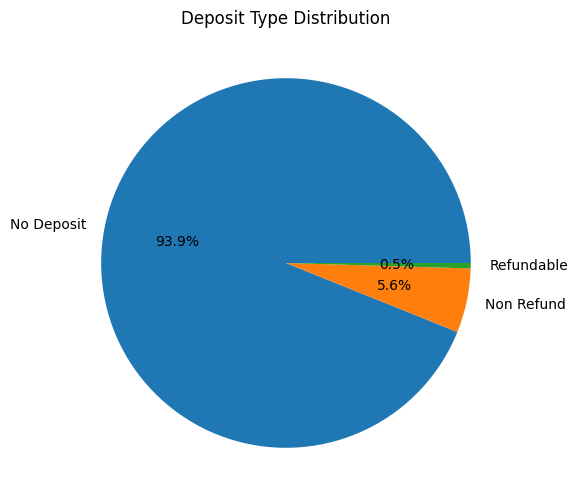

In [54]:
# Подсчет количества значений в столбце "deposit_type"
deposit_counts = df_resort_all['deposit_type'].value_counts()

# Создание круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(deposit_counts, labels=deposit_counts.index, autopct='%1.1f%%')
plt.title('Deposit Type Distribution')
plt.show()

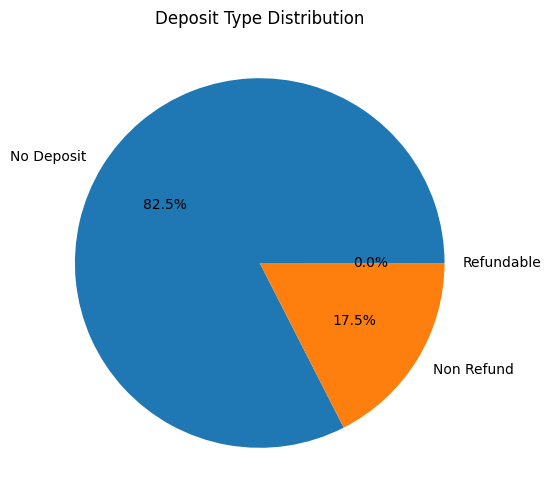

In [55]:
# Подсчет количества значений в столбце "deposit_type"
deposit_counts2 = df_city_all['deposit_type'].value_counts()

# Создание круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(deposit_counts2, labels=deposit_counts2.index, autopct='%1.1f%%')
plt.title('Deposit Type Distribution')
plt.show()

Большинство бронирований типа no deposit: 93.9% в resort отелях, 82.5% в city отелях. Тип refundable занимает в обоих случаях менее 1%, поэтому не играет особой роли. А тип non refund в city отелях занимает значительное место - 17.5%, а в resort отелях лишь 5.6%.

##Шаг 5. Создание новых признаков

Мы создали новые признаки в шаге с гипотезами.

monthly_arrivals_2019,
monthly_arrivals_2020,
cancellations_city_2019 и т.д.

## Шаг 6. Проверка гипотез



### Влияние пандемии Covid на деятельность отелей будет анализироваться через следующие различия между данными для 2019 и 2020 года:

1. Количество бронирований по месяцам или неделям года, сравнение средних значений между годами.
2. Отмены бронирований.



__1.Количество бронирований по месяцам года (процентное изменение количества бронирований), сравнение средних значений между годами.__

##Графики arrival_date_month для 2019 и 2020 годов

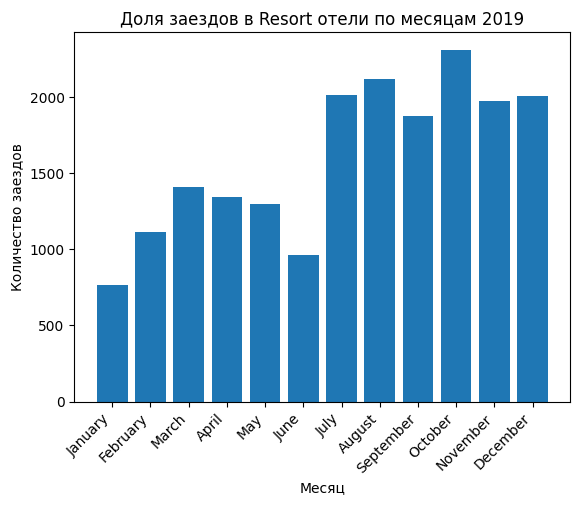

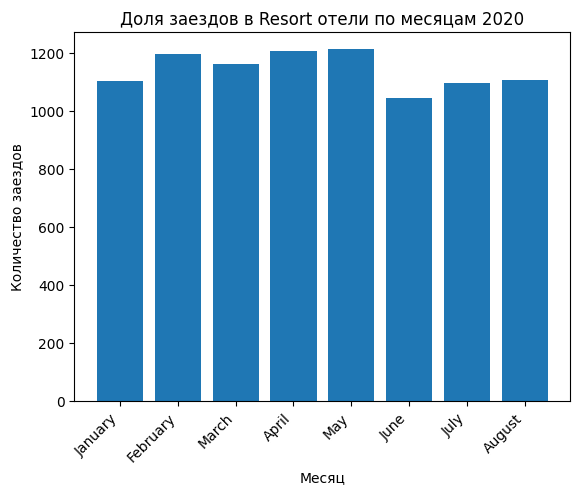

In [56]:
# создание таблицы с количеством прибытий в каждый месяц в 2019 и 2020 году для resort отеля
monthly_arrivals_2019 = df_resort.groupby('arrival_date_month').size()
monthly_arrivals_2020 = df_2020_resort.groupby('arrival_date_month').size()

# упорядочиваем значения по оси X
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_arrivals_2019 = monthly_arrivals_2019.reindex(month_order)
monthly_arrivals_2020 = monthly_arrivals_2020.reindex(month_order)

# создание столбиковой диаграммы
plt.bar(monthly_arrivals_2019.index, monthly_arrivals_2019)
plt.title('Доля заездов в Resort отели по месяцам 2019')
plt.xlabel('Месяц')
plt.ylabel('Количество заездов')
plt.xticks(rotation=45, ha='right')
plt.show()

# создание столбиковой диаграммы
plt.bar(monthly_arrivals_2020.index, monthly_arrivals_2020)
plt.title('Доля заездов в Resort отели по месяцам 2020')
plt.xlabel('Месяц')
plt.ylabel('Количество заездов')
plt.xticks(rotation=45, ha='right')
plt.show()


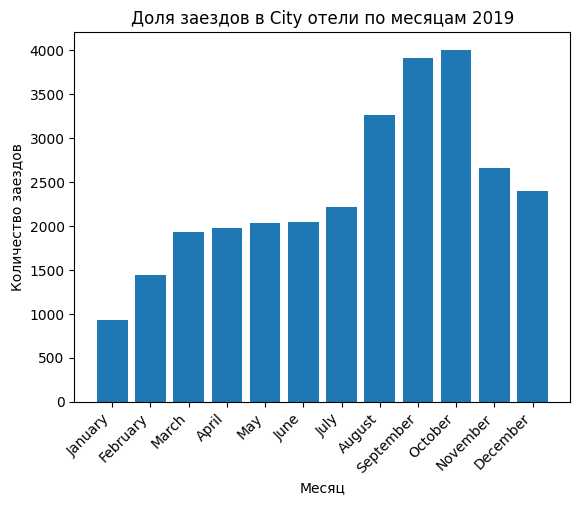

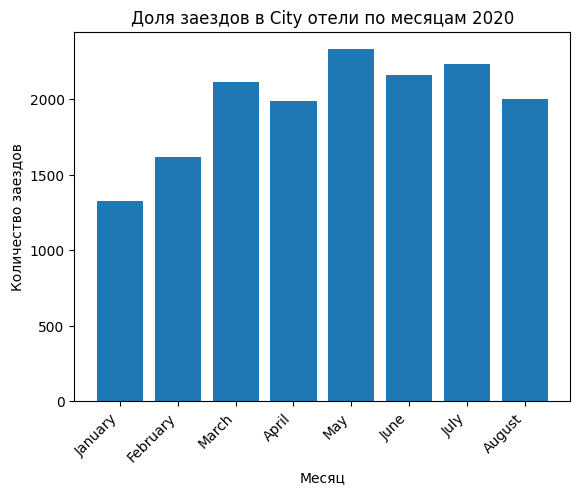

In [57]:
# создание таблицы с количеством прибытий в каждый месяц в 2019 и 2020 году для resort отеля
monthlyy_arrivals_2019 = df_city.groupby('arrival_date_month').size()
monthlyy_arrivals_2020 = df_2020_city.groupby('arrival_date_month').size()

# упорядочиваем значения по оси X
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthlyy_arrivals_2019 = monthlyy_arrivals_2019.reindex(month_order)
monthlyy_arrivals_2020 = monthlyy_arrivals_2020.reindex(month_order)

# создание столбиковой диаграммы
plt.bar(monthlyy_arrivals_2019.index, monthlyy_arrivals_2019)
plt.title('Доля заездов в City отели по месяцам 2019')
plt.xlabel('Месяц')
plt.ylabel('Количество заездов')
plt.xticks(rotation=45, ha='right')
plt.show()

# создание столбиковой диаграммы
plt.bar(monthlyy_arrivals_2020.index, monthlyy_arrivals_2020)
plt.title('Доля заездов в City отели по месяцам 2020')
plt.xlabel('Месяц')
plt.ylabel('Количество заездов')
plt.xticks(rotation=45, ha='right')
plt.show()

Месяца, представленные на диаграммах расположены по порядку в рамках календарного года.
Можно отметить, что в 2019 году наиболее востребованный месяц для посещений в отелях и типа resort, и типа city - октябрь. Далее в resort отелях идут август, июль, декабрь, ноябрь. А в city ателях - сентябрь, август, ноябрь, декабрь.

На основе данных заключений можно сделать вывод, что в 2019 году в отелях обоих типов явно наблюдалась сезонность и наиболее повышенный спрос в определенный временной промежуток времени: с июля по декабрь, достигая максимального значения в октябре, то есть данный месяц являлся максимально загруженным.

Наблюдаются небольшие различия между 2019 и 2020 годами.

__Проверим гипотезу о том, что среднее значение количеств бронирований в 2020 году меньше, чем в 2019, alpha = 5%__

H0 (нулевая гипотеза): Среднее значение количества бронирований в 2020 году равно или больше среднего значения в 2019 году.

H1 (альтернативная гипотеза): Среднее значение количества бронирований в 2020 году меньше среднего значения в 2019 году.

Используем t-test, т.к. у нас много значений и по ЦПТ среднее будет стремиться к нормальному распределению. Также понимаем, что наблюдения независимы. Истинные дисперсии неизвестны.

In [58]:
# Выполнение одновыборочного t-теста для City отеля
t_statistic_city, p_value_city = sts.ttest_1samp(monthlyy_arrivals_2019[:8], monthlyy_arrivals_2020[:8].mean())

# Вывод результатов для City отеля
print("City отель:")
print("T-статистика:", t_statistic_city)
print("P-значение:", p_value_city)

# Выполнение одновыборочного t-теста для Resort отеля
t_statistic_resort, p_value_resort = sts.ttest_1samp(monthly_arrivals_2019[:8], monthly_arrivals_2020[:8].mean())

# Вывод результатов для Resort отеля
print("Resort отель:")
print("T-статистика:", t_statistic_resort)
print("P-значение:", p_value_resort)

City отель:
T-статистика: 0.024402350579250123
P-значение: 0.9812127381851218
Resort отель:
T-статистика: 1.4167823826148465
P-значение: 0.1994774114358101


Получается, что в обоих случаях статистически значимых различий нет. Скорее всего, это потому что у нас нет данных по 2020 году с сентября по декабрь. К тому же, для обоих отелей пиковыми были осенние месяцы, которые не вошли в сравнение. Мы рассматривали данные без отмен, будем надеяться, что при проверке гипотез по отменам будут найдены статисьтчески значимые различия, которые покажут влияние пандемии на деятельность отелей.

__2.Отмены бронирований: процент отмененных бронирований.__

## Проанализируем сколько было отмен

In [51]:
# Подсчет количества значений "1" в столбце "is_canceled"
count_cancelled = df_resort_all["is_canceled"].value_counts()[1]

# Подсчет количества значений "1" в столбце "is_canceled"
countt_cancelled = df_city_all["is_canceled"].value_counts()[1]

# Подсчет количества значений "0" в столбце "is_canceled"
count_cancelled = df_resort_all["is_canceled"].value_counts()[0]

# Подсчет количества значений "0" в столбце "is_canceled"
count_cancelled = df_city_all["is_canceled"].value_counts()[0]

print("Количество отмен в отелях типа Resort:", count_cancelled)
print("Количество отмен в отелях типа City:", countt_cancelled)
print("Количество неотмененных бронирований в Resort отелях:", count_cancelled)
print("Количество неотмененных бронирований в City отелях:", count_cancelled)

Количество отмен в отелях типа Resort: 30406
Количество отмен в отелях типа City: 21402
Количество неотмененных бронирований в Resort отелях: 30406
Количество неотмененных бронирований в City отелях: 30406


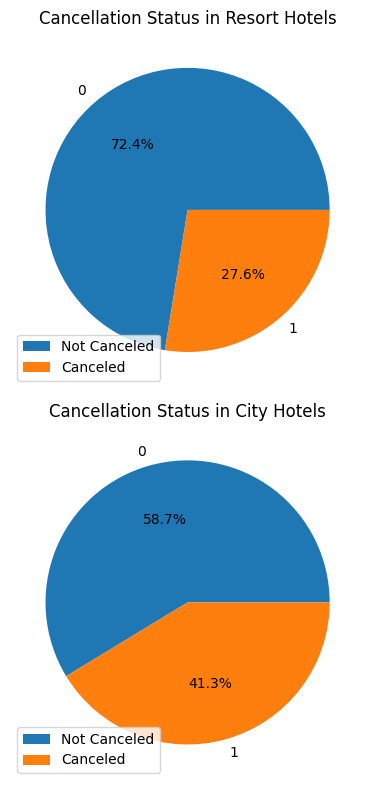

In [52]:
# Подсчет количества отмененных и подтвержденных бронирований в df_resort_all
canceled_counts_resort = df_resort_all['is_canceled'].value_counts()
canceled_percentages_resort = canceled_counts_resort / canceled_counts_resort.sum() * 100

# Подсчет количества отмененных и подтвержденных бронирований в df_city_all
canceled_counts_city = df_city_all['is_canceled'].value_counts()
canceled_percentages_city = canceled_counts_city / canceled_counts_city.sum() * 100

# Создание первой круговой диаграммы для df_resort
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.pie(canceled_percentages_resort, labels=canceled_percentages_resort.index, autopct='%.1f%%')
plt.title('Cancellation Status in Resort Hotels')
plt.legend(['Not Canceled', 'Canceled'], loc='best')

# Создание второй круговой диаграммы для df_city
plt.subplot(2, 1, 2)
plt.pie(canceled_percentages_city, labels=canceled_percentages_city.index, autopct='%.1f%%')
plt.title('Cancellation Status in City Hotels')
plt.legend(['Not Canceled', 'Canceled'], loc='best')

plt.tight_layout()
plt.show()

__То же самое для 2020 года__

In [92]:
# Подсчет количества значений "1" в столбце "is_canceled"
count_cancelled_2020 = df_2020_resort_all["is_canceled"].value_counts()[1]

# Подсчет количества значений "1" в столбце "is_canceled"
countt_cancelled_2020 = df_2020_city_all["is_canceled"].value_counts()[1]

# Подсчет количества значений "0" в столбце "is_canceled"
count_cancelled_2020 = df_2020_resort_all["is_canceled"].value_counts()[0]

# Подсчет количества значений "0" в столбце "is_canceled"
count_cancelled_2020 = df_2020_city_all["is_canceled"].value_counts()[0]

print("Количество отмен в отелях типа Resort:", count_cancelled_2020)
print("Количество отмен в отелях типа City:", countt_cancelled_2020)
print("Количество неотмененных бронирований в Resort отелях:", count_cancelled_2020)
print("Количество неотмененных бронирований в City отелях:", count_cancelled_2020)

Количество отмен в отелях типа Resort: 15766
Количество отмен в отелях типа City: 11680
Количество неотмененных бронирований в Resort отелях: 15766
Количество неотмененных бронирований в City отелях: 15766


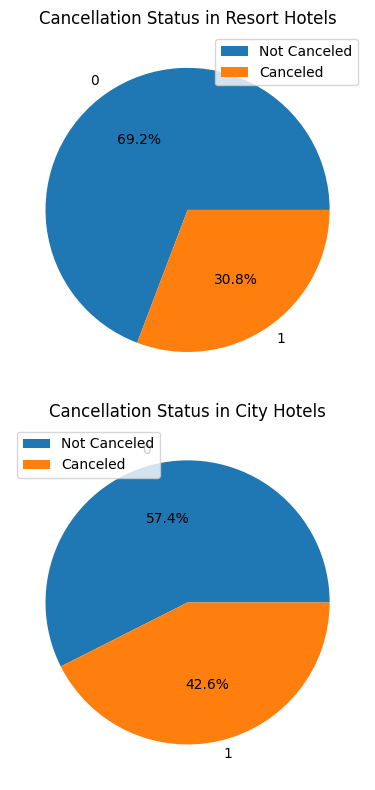

In [93]:
# Подсчет количества отмененных и подтвержденных бронирований в df_resort_all
canceled_counts_resort_2020 = df_2020_resort_all['is_canceled'].value_counts()
canceled_percentages_resort_2020 = canceled_counts_resort_2020 / canceled_counts_resort_2020.sum() * 100

# Подсчет количества отмененных и подтвержденных бронирований в df_city_all
canceled_counts_city_2020 = df_2020_city_all['is_canceled'].value_counts()
canceled_percentages_city_2020 = canceled_counts_city_2020 / canceled_counts_city_2020.sum() * 100

# Создание первой круговой диаграммы для df_resort
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.pie(canceled_percentages_resort_2020, labels=canceled_percentages_resort_2020.index, autopct='%.1f%%')
plt.title('Cancellation Status in Resort Hotels')
plt.legend(['Not Canceled', 'Canceled'], loc='best')

# Создание второй круговой диаграммы для df_city
plt.subplot(2, 1, 2)
plt.pie(canceled_percentages_city_2020, labels=canceled_percentages_city_2020.index, autopct='%.1f%%')
plt.title('Cancellation Status in City Hotels')
plt.legend(['Not Canceled', 'Canceled'], loc='best')

plt.tight_layout()
plt.show()

## Посмотрим количество отмен в течение года

<Figure size 1000x600 with 0 Axes>

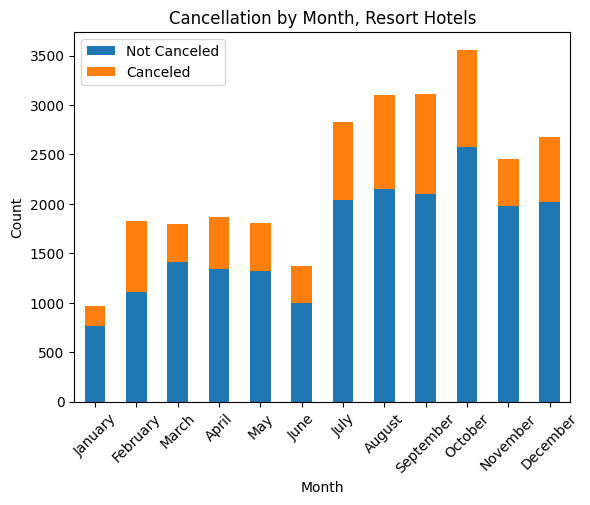

<Figure size 1000x600 with 0 Axes>

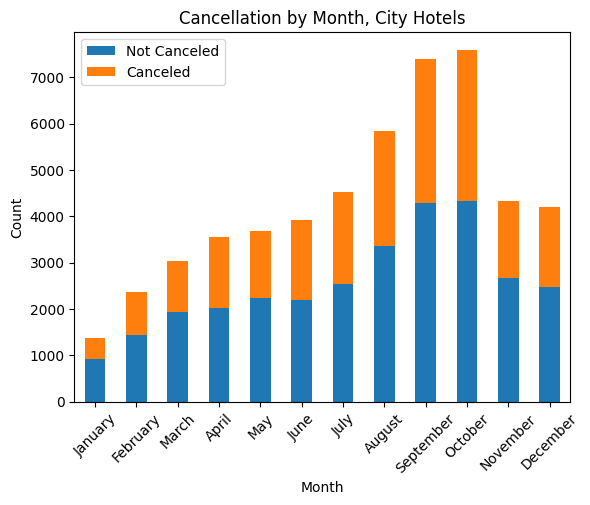

In [53]:
# Группировка данных по месяцу и подсчет количества отмен и бронирований в resort отелях
grouped_data = df_resort_all.groupby("arrival_date_month")["is_canceled"].value_counts().unstack()

# Установка правильного порядка месяцев
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
grouped_data = grouped_data.reindex(month_order)

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))
grouped_data.plot(kind="bar", stacked=True)
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Cancellation by Month, Resort Hotels")
plt.legend(["Not Canceled", "Canceled"])
plt.xticks(rotation=45)
plt.show(block=False)

# Группировка данных по месяцу и подсчет количества отмен и бронирований в city отелях
groupedd_data = df_city_all.groupby("arrival_date_month")["is_canceled"].value_counts().unstack()

# Установка правильного порядка месяцев
groupedd_data = groupedd_data.reindex(month_order)

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))
groupedd_data.plot(kind="bar", stacked=True)
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Cancellation by Month, City Hotels")
plt.legend(["Not Canceled", "Canceled"])
plt.xticks(rotation=45)
plt.show(block=False)

__То же самое для 2020 года__


<Figure size 1000x600 with 0 Axes>

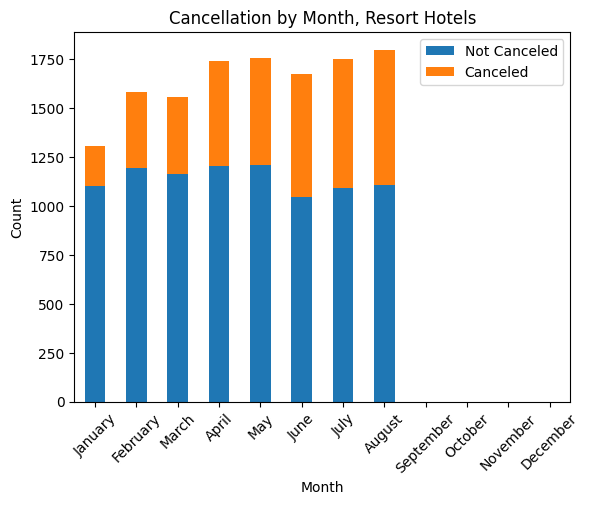

<Figure size 1000x600 with 0 Axes>

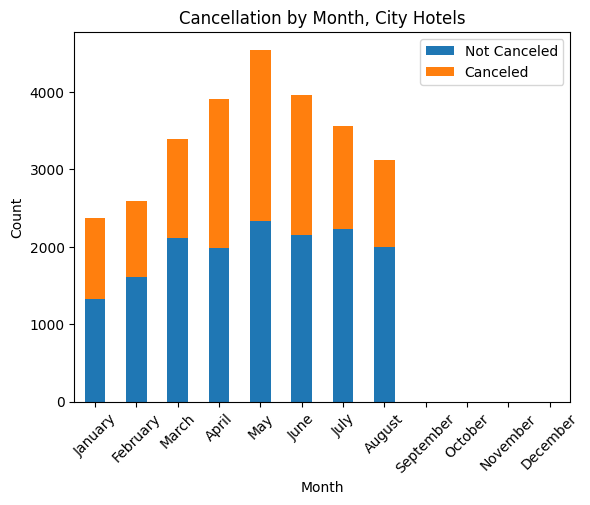

In [94]:
# Группировка данных по месяцу и подсчет количества отмен и бронирований в resort отелях
grouped_data_2020 = df_2020_resort_all.groupby("arrival_date_month")["is_canceled"].value_counts().unstack()

# Установка правильного порядка месяцев
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
grouped_data_2020 = grouped_data_2020.reindex(month_order)

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))
grouped_data_2020.plot(kind="bar", stacked=True)
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Cancellation by Month, Resort Hotels")
plt.legend(["Not Canceled", "Canceled"])
plt.xticks(rotation=45)
plt.show(block=False)

# Группировка данных по месяцу и подсчет количества отмен и бронирований в city отелях
groupedd_data_2020 = df_2020_city_all.groupby("arrival_date_month")["is_canceled"].value_counts().unstack()

# Установка правильного порядка месяцев
groupedd_data_2020 = groupedd_data_2020.reindex(month_order)

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))
groupedd_data_2020.plot(kind="bar", stacked=True)
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Cancellation by Month, City Hotels")
plt.legend(["Not Canceled", "Canceled"])
plt.xticks(rotation=45)
plt.show(block=False)

__Проверим гипотезу__

H0 (нулевая гипотеза): Средние значения количества отмен бронирований в 2019 и 2020 равны

H1 (альтернативная гипотеза): Среднее значение количества отмен в 2020 году больше


In [59]:
# Фильтрация данных за январь-август для 2019 года
df_city_2019_filtered = df_city_all[\
    df_city_all['arrival_date_month'].isin(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August'])\
]

df_resort_2019_filtered = df_resort_all[\
    df_resort_all['arrival_date_month'].isin(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August'])\
]

# Фильтрация данных за январь-август для 2020 года
df_city_2020_filtered = df_2020_city_all[\
    df_2020_city_all['arrival_date_month'].isin(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August'])\
]

df_resort_2020_filtered = df_2020_resort_all[\
    df_2020_resort_all['arrival_date_month'].isin(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August'])\
]

# Выбираем данные только для отмененных бронирований в 2019 году для каждого отеля
cancellations_city_2019 = df_city_2019_filtered[df_city_2019_filtered['is_canceled'] == 1]\
    .groupby('arrival_date_month')['is_canceled'].count()

cancellations_resort_2019 = df_resort_2019_filtered[df_resort_2019_filtered['is_canceled'] == 1]\
    .groupby('arrival_date_month')['is_canceled'].count()

# Выбираем данные только для отмененных бронирований в 2020 году для каждого отеля
cancellations_city_2020 = df_city_2020_filtered[df_city_2020_filtered['is_canceled'] == 1]\
    .groupby('arrival_date_month')['is_canceled'].count()

cancellations_resort_2020 = df_resort_2020_filtered[df_resort_2020_filtered['is_canceled'] == 1]\
    .groupby('arrival_date_month')['is_canceled'].count()

# H0 (нулевая гипотеза): Средние значения количества отмен бронирований равны
# H1 (альтернативная гипотеза): Среднее значение количества отмен в 2020 году больше

# Выполняем t-тест для независимых выборок для City отеля
t_statistic_city, p_value_city = sts.ttest_ind(cancellations_city_2019, cancellations_city_2020, alternative='greater')

# Вывод результатов для City отеля
print("City отель:")
print("T-статистика:", t_statistic_city)
print("P-значение:", p_value_city)

# Выполняем t-тест для независимых выборок для Resort отеля

t_statistic_resort, p_value_resort = sts.ttest_ind(cancellations_resort_2019, cancellations_resort_2020, alternative='greater')

# Вывод результатов для Resort отеля
print("Resort отель:")
print("T-статистика:", t_statistic_resort)
print("P-значение:", p_value_resort)

alpha = 0.05

# Проверяем, отвергаем или принимаем нулевую гипотезу для City отеля
if p_value_city < alpha:
    print("Отвергаем нулевую гипотезу для City отеля. Среднее значение количества отмен в 2020 году больше.")
else:
    print("Не отвергаем нулевую гипотезу для City отеля. Средние значения количества отмен равны или количество отмен в 2020 году не больше.")

# Проверяем, отвергаем или принимаем нулевую гипотезу для Resort отеля
if p_value_resort < alpha:
    print("Отвергаем нулевую гипотезу для Resort отеля. Среднее значение количества отмен в 2020 году больше.")
else:
    print("Не отвергаем нулевую гипотезу для Resort отеля. Средние значения количества отмен равны или количество отмен в 2020 году не больше.")

City отель:
T-статистика: -0.02340292936083938
P-значение: 0.5091704175522225
Resort отель:
T-статистика: 0.4142900759631832
P-значение: 0.3424696359081858
Не отвергаем нулевую гипотезу для City отеля. Средние значения количества отмен равны или количество отмен в 2020 году не больше.
Не отвергаем нулевую гипотезу для Resort отеля. Средние значения количества отмен равны или количество отмен в 2020 году не больше.


Снова не нашлось статистических различий между отменами в 2019 и 2020 году. Предполагаем, что это связано с недостаточным соответствием действительности используемого датасета, либо же действительно данные отели в первые полгода пандемии смогли избежать сильного снижения бронирований и повышения отмен.

### Шаг 7. МО

Мы будем обучать модели для прогнозирования отмены бронирования. Это может помочь отелю для прогнозирования нагрузки, возможно с помощью такого прогноза отель сможет продавать больше номеров чем обычно и терять меньше денег на внезапных отменах бронирований.

Прежде чем перейти к непосредственному МО - обработаем данные.

Посмотрим на корреляционную матрицу

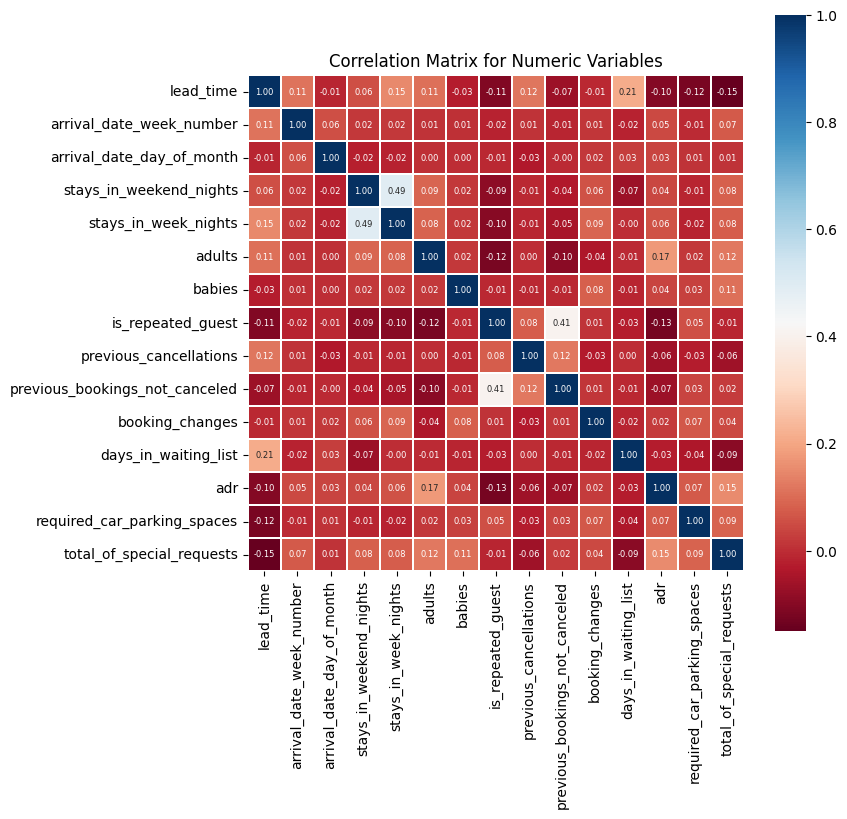

In [60]:
# Выбираем столбцы с типами int64 и float64
colnames = df.select_dtypes(include=['int64', 'float64']).columns

# Удаляем столбцы 'arrival_date_year' и 'is_canceled'
colnames = colnames.drop(['arrival_date_year', 'is_canceled'])

# Построение матрицы корреляции
correlation_matrix = df[colnames].corr(method='pearson')

# Создание тепловой карты
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, square=True, annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu", annot_kws={"fontsize":6})
plt.title('Correlation Matrix for Numeric Variables')
plt.show()

Анализируя полученную матрицу, можно сказать, что:
1. Если значение корреляции близко к 1, это указывает на положительную линейную связь между переменными. Это означает, что при увеличении значения одной переменной, вероятно, будет увеличиваться и значение другой переменной, и наоборот. Чем ближе значение к 1, тем сильнее связь.
2. Если значение корреляции близко к -1, это указывает на отрицательную линейную связь между переменными. Это означает, что при увеличении значения одной переменной, вероятно, будет уменьшаться значение другой переменной, и наоборот. Чем ближе значение к -1, тем сильнее связь.
3. Если значение корреляции близко к 0, это указывает на отсутствие линейной связи между переменными. Это означает, что изменение значения одной переменной не предсказуемо связано с изменением значения другой переменной.

In [61]:
# вычислим абсолютные значения корреляции между признаком "is_canceled" и всеми остальными признаками в DataFrame df
correlation = df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

<ipython-input-61-6f471caa8163>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()['is_canceled'].abs().sort_values(ascending = False)


is_canceled                       1.000000
lead_time                         0.327169
total_of_special_requests         0.246207
required_car_parking_spaces       0.201122
booking_changes                   0.146189
previous_cancellations            0.140910
days_in_waiting_list              0.067892
is_repeated_guest                 0.059227
previous_bookings_not_canceled    0.052053
adults                            0.048872
babies                            0.028407
adr                               0.016307
stays_in_weekend_nights           0.011470
stays_in_week_nights              0.011194
arrival_date_day_of_month         0.008805
arrival_date_week_number          0.005374
arrival_date_year                      NaN
Name: is_canceled, dtype: float64

В ходе анализа корреляции и непосредственной абсолютной корреляции между is_canceled и другими столбцами, мы видим, что не везде присутсвует сильная связь.

In [62]:
# уберем колонки, которые не понадобятся в ходе машинного обучения

dropp_col = ['days_in_waiting_list', 'arrival_date_year', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
               'reservation_status', 'country', 'days_in_waiting_list']

df.drop(dropp_col, axis = 1, inplace = True)

In [63]:
# создадим числовые и категориальные датасеты

category_cols = [col for col in df.columns if df[col].dtype == 'O']
category_cols

['hotel',
 'arrival_date_month',
 'children',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'agent',
 'company',
 'customer_type',
 'reservation_status_date']

In [64]:
category_df = df[category_cols]

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
category_df['reservation_status_date'] = pd.to_datetime(category_df['reservation_status_date'])

category_df['year'] = category_df['reservation_status_date'].dt.year
category_df['month'] = category_df['reservation_status_date'].dt.month
category_df['day'] = category_df['reservation_status_date'].dt.day

In [67]:
category_df.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)

In [68]:
for col in category_df.columns:
    print(f"{col}: \n{category_df[col].unique()}\n")

hotel: 
['Resort Hotel' 'City Hotel']

children: 
[2.0 0.0 1.0 3.0 '0' 10.0]

meal: 
['BB' 'HB' 'SC' 'FB']

market_segment: 
['Online TA' 'Groups' 'Offline TA/TO' 'Direct' 'Complementary' 'Corporate'
 'Aviation' 'Undefined']

distribution_channel: 
['TA/TO' 'Direct' 'Corporate' 'GDS' 'Undefined']

reserved_room_type: 
['G' 'A' 'E' 'D' 'F' 'C' 'H' 'B' 'L']

deposit_type: 
['No Deposit' 'Non Refund' 'Refundable']

agent: 
[240.0 305.0 306.0 '0' 242.0 332.0 250.0 171.0 156.0 8.0 241.0 15.0 330.0
 126.0 94.0 6.0 177.0 196.0 314.0 134.0 38.0 348.0 68.0 310.0 96.0 339.0
 115.0 184.0 375.0 2.0 66.0 327.0 387.0 142.0 298.0 273.0 67.0 146.0 36.0
 91.0 245.0 71.0 253.0 95.0 248.0 385.0 257.0 5.0 175.0 393.0 147.0 249.0
 315.0 243.0 168.0 143.0 251.0 40.0 26.0 75.0 128.0 9.0 307.0 11.0 181.0
 244.0 69.0 261.0 3.0 1.0 368.0 127.0 336.0 105.0 291.0 411.0 481.0 275.0
 10.0 154.0 139.0 14.0 21.0 7.0 19.0 22.0 87.0 37.0 28.0 44.0 86.0 85.0
 83.0 159.0 210.0 214.0 155.0 118.0 129.0 179.0 138.0 174.0 29

Выполним некоторые преобразования категориальных признаков в числовые значения с использованием отображений.

In [69]:
category_df['hotel'] = category_df['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

category_df['meal'] = category_df['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

category_df['market_segment'] = category_df['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

category_df['distribution_channel'] = category_df['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

category_df['reserved_room_type'] = category_df['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6,
                                                                   'L': 7, 'B': 8})

category_df['deposit_type'] = category_df['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

category_df['customer_type'] = category_df['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

category_df['year'] = category_df['year'].map({2019: 1})

In [70]:
numerical_df = df.drop(columns = category_cols, axis = 1)
numerical_df.drop('is_canceled', axis = 1, inplace = True)
numerical_df

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,required_car_parking_spaces,total_of_special_requests
0,20,1,1,0,2,2,0,0,0,0,119.00,0,0
1,76,1,1,1,2,2,0,0,0,0,57.90,0,1
2,113,1,2,0,1,2,0,0,0,0,72.00,0,0
3,113,1,2,0,1,2,0,0,0,0,72.00,0,0
4,113,1,2,0,1,2,0,0,0,0,72.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79259,61,10,1,4,10,2,0,0,0,0,29.00,0,0
79260,219,10,2,2,5,2,0,0,0,0,52.00,0,0
79261,219,10,2,2,5,2,0,0,0,0,52.00,0,0
79262,219,10,2,2,5,2,0,0,0,0,52.00,0,0


Посмотрим дисперсию для для каждого столбца

In [71]:
numerical_df.var()

lead_time                         11227.843831
arrival_date_week_number            180.317848
arrival_date_day_of_month            76.376514
stays_in_weekend_nights               0.975817
stays_in_week_nights                  3.483829
adults                                0.375194
babies                                0.010941
is_repeated_guest                     0.029225
previous_cancellations                1.053424
previous_bookings_not_canceled        1.778812
adr                                2322.068385
required_car_parking_spaces           0.062134
total_of_special_requests             0.573985
dtype: float64

Далее применим логарифмические функции к определенным числовым столбцам в DataFrame numerical_df в случае, если в них содержатся нулевые или отрицательные значения.

In [72]:
numerical_df['lead_time'] = np.log(numerical_df['lead_time'] + 1)
numerical_df['arrival_date_week_number'] = np.log(numerical_df['arrival_date_week_number'] + 1)
numerical_df['arrival_date_day_of_month'] = np.log(numerical_df['arrival_date_day_of_month'] + 1)
numerical_df['adr'] = np.log(numerical_df['adr'] + 1)

In [73]:
numerical_df['adr'] = numerical_df['adr'].fillna(value = numerical_df['adr'].mean())

Произведем объединение двух DataFrame - category_df и numerical_df - в один DataFrame X по горизонтальной оси.

In [74]:
X = pd.concat([category_df, numerical_df], axis = 1)
y = df['is_canceled']

In [75]:
X.shape, y.shape

((79150, 26), (79150,))

In [76]:
# Разделение данных на обучающий и тестовый наборы с зафиксированным random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
y_train.head(), y_test.head()

(384      1
 29022    0
 19943    0
 2852     1
 42975    0
 Name: is_canceled, dtype: int64,
 43533    0
 56957    1
 42078    0
 71051    0
 27282    0
 Name: is_canceled, dtype: int64)

Теперь перейдем непосредственно к машинному обучению.

В последующем анализе мы будем оценивать работу обученныз моделей на таких параметрах, как Accuracy, Precision Recall, F1-Score, AUC-ROC, поскольку;
- Precision (точность) показывает, какая доля объектов, отнесенных моделью к положительному классу, действительно является положительными. Высокая точность означает, что модель делает меньше ложных положительных прогнозов.
- Recall (полнота) показывает, какая доля истинно положительных объектов была правильно обнаружена моделью. Высокая полнота означает, что модель правильно обнаруживает большую долю положительных объектов.
- F1-Score комбинирует точность и полноту в одну метрику, которая учитывает их гармоническое среднее. Высокое значение F1-Score указывает на баланс между точностью и полнотой модели.
- AUC-ROC (Area Under the Receiver Operating Characteristic curve) измеряет способность модели разделять классы путем вычисления площади под кривой ROC. Кривая ROC представляет собой график, на котором отображается зависимость между True Positive Rate (чувствительность) и False Positive Rate (специфичность) при изменении порога классификации модели. Значение AUC-ROC находится в диапазоне от 0 до 1, где высокое значение указывает на хорошую способность модели разделять классы.

Сначала попробуем обучить модель на основе логистической регрессии. Это один из методов обучения с учителем, применяемых в машинном обучении, который используется для решения задач классификации. Мы начнем именно с нее, потому что это наиболее универсальный и простой метод, в том числе, для интерпретации. И он хорошо работает с категориальными признаками, обладает меньшей склонностью к переобучению.

In [78]:
# Создание объекта Imputer с указанием стратегии заполнения (среднее значение)
imputer = SimpleImputer(strategy='mean')

# Применение Imputer к признакам с пропущенными значениями
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Обучение модели LogisticRegression с обработанными данными
lr = LogisticRegression()
lr.fit(X_train_imputed, y_train)

# Прогнозирование и оценка модели
y_pred_lr = lr.predict(X_test_imputed)
acc_lr = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression is : 0.8117498420720152
Confusion Matrix : 
[[9579  538]
 [2442 3271]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     10117
           1       0.86      0.57      0.69      5713

    accuracy                           0.81     15830
   macro avg       0.83      0.76      0.78     15830
weighted avg       0.82      0.81      0.80     15830



Произведем оценку данной модели.

In [79]:
# Вычисление метрик
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
auc_roc = roc_auc_score(y_test, y_pred_lr)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

Precision: 0.8587555788920976
Recall: 0.5725538246105374
F1-Score: 0.6870405377021634
AUC-ROC: 0.7596880025494122


В целом, результаты оценки модели показывают, что модель имеет приемлемую точность и способность предсказывать отмены бронирования. Однако, полнота и способность различать классы являются относительно ниже, что может означать, что модель не всегда обнаруживает все реальные отмены бронирования.

Попробуем другие методы машинного обучения, например, DecisionTreeClassifier, который основан на построении дерева решений, где каждый узел представляет собой тест на значении одного из признаков, а каждое ребро соответствует возможному значению этого признака. Листья дерева соответствуют конкретным классам или меткам. Мы выбрали его, потому что он также прост в интерпретации, универсален и довольно быстро обучаем. Однако склонен к переобучению и ограничен в сложности модели.

In [80]:
# Создание объекта Imputer с указанием стратегии заполнения (среднее значение) для пропущенных значений
imputer = SimpleImputer(strategy='mean')

# Применение Imputer к признакам с пропущенными значениями
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

dtc = DecisionTreeClassifier()
dtc.fit(X_train_imputed, y_train)

y_pred_dtc = dtc.predict(X_test_imputed)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Decision Tree is : 0.947820593809223
Confusion Matrix : 
[[9694  423]
 [ 403 5310]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10117
           1       0.93      0.93      0.93      5713

    accuracy                           0.95     15830
   macro avg       0.94      0.94      0.94     15830
weighted avg       0.95      0.95      0.95     15830



Оценим модель.

In [81]:
# Вычисление метрик
precision = precision_score(y_test, y_pred_dtc)
recall = recall_score(y_test, y_pred_dtc)
f1 = f1_score(y_test, y_pred_dtc)
auc_roc = roc_auc_score(y_test, y_pred_dtc)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

Precision: 0.9262166405023547
Recall: 0.9294591283038683
F1-Score: 0.9278350515463918
AUC-ROC: 0.9438241574108055


По полученным результытам, мы можем сказать, что модель Decision Tree Classifier работает лучше чем модель на основе логистической регресии. Т.к. все основные параметры для оценки модели увеличились.

Однако, попробуем еще варинты машинного обучения: CatBoostClassifier - алгоритм градиентного бустинга, который предназначен для задач классификации. Он основан на деревьях решений и предлагает ряд улучшений и оптимизаций для повышения производительности и качества модели. Мы выбрали его, потому что он хорошо работает с категориальными признаками, обрабатывает пропущенные значения, работает с кодированием данных, имеет встроенный механизм регуляризации для предотвращения переобучения.

In [82]:
cat = CatBoostClassifier(iterations=100)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

Learning rate set to 0.5
0:	learn: 0.4654331	total: 71.2ms	remaining: 7.05s
1:	learn: 0.3906754	total: 109ms	remaining: 5.32s
2:	learn: 0.3595025	total: 126ms	remaining: 4.08s
3:	learn: 0.3257111	total: 145ms	remaining: 3.48s
4:	learn: 0.2963266	total: 164ms	remaining: 3.11s
5:	learn: 0.2565470	total: 182ms	remaining: 2.85s
6:	learn: 0.2398148	total: 213ms	remaining: 2.83s
7:	learn: 0.2059038	total: 234ms	remaining: 2.69s
8:	learn: 0.1976784	total: 252ms	remaining: 2.55s
9:	learn: 0.1773399	total: 271ms	remaining: 2.44s
10:	learn: 0.1653325	total: 300ms	remaining: 2.43s
11:	learn: 0.1541829	total: 325ms	remaining: 2.38s
12:	learn: 0.1429272	total: 345ms	remaining: 2.31s
13:	learn: 0.1223553	total: 374ms	remaining: 2.3s
14:	learn: 0.1175309	total: 403ms	remaining: 2.28s
15:	learn: 0.1147061	total: 424ms	remaining: 2.23s
16:	learn: 0.1088741	total: 443ms	remaining: 2.16s
17:	learn: 0.1042588	total: 461ms	remaining: 2.1s
18:	learn: 0.1006746	total: 481ms	remaining: 2.05s
19:	learn: 0.0983

In [83]:
print(f"Accuracy Score of Cat Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Cat Boost Classifier is : 0.9960202147820594
Confusion Matrix : 
[[10108     9]
 [   54  5659]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10117
           1       1.00      0.99      0.99      5713

    accuracy                           1.00     15830
   macro avg       1.00      0.99      1.00     15830
weighted avg       1.00      1.00      1.00     15830



Оценим данную модель.

In [84]:
precision = precision_score(y_test, y_pred_cat)
recall = recall_score(y_test, y_pred_cat)
f1 = f1_score(y_test, y_pred_cat)
auc_roc = roc_auc_score(y_test, y_pred_cat)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

Precision: 0.9984121383203952
Recall: 0.9905478732714861
F1-Score: 0.9944644583077058
AUC-ROC: 0.9948291407476338


По полученным результатам, мы можем сказать, что модель CatBoostClassifier работает лучше чем модель Decision Tree Classifier. Т.к. все основные параметры для оценки модели увеличились.

Поробуем еще одну модель - RandomForestClassifier. Мы также выбрали RandomForestClassifier, поскольку он хорошо работает с большими объемами данных, устойчив к переобучению, устойчив к шуму и выбросам и хорошо обрабатывает категориальные и числовые признаки.

In [85]:
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

rd_clf = RandomForestClassifier()
rd_clf.fit(X_train_imputed, y_train)

y_pred_rd_clf = rd_clf.predict(X_test_imputed)

acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
conf = confusion_matrix(y_test, y_pred_rd_clf)
clf_report = classification_report(y_test, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is: {acc_rd_clf}")
print(f"Confusion Matrix:\n{conf}")
print(f"Classification Report:\n{clf_report}")

Accuracy Score of Random Forest is: 0.9596336070751738
Confusion Matrix:
[[10036    81]
 [  558  5155]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10117
           1       0.98      0.90      0.94      5713

    accuracy                           0.96     15830
   macro avg       0.97      0.95      0.96     15830
weighted avg       0.96      0.96      0.96     15830



Оценим данную модель.

In [86]:
# Вычесление метрик
precision = precision_score(y_test, y_pred_rd_clf)
recall = recall_score(y_test, y_pred_rd_clf)
f1 = f1_score(y_test, y_pred_rd_clf)
auc_roc = roc_auc_score(y_test, y_pred_rd_clf)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"AUC-ROC: {auc_roc}")

Precision: 0.9845301757066462
Recall: 0.9023280238053561
F1-score: 0.9416385057996164
AUC-ROC: 0.9471608489096961


Полученные результаты высоки, но ниже аналогичных для модели на основе CatBoostClassifier.

И последнюю модель мы обучали на основе AdaBoostClassifier. Поскольку он представляет собой комбинацию слабых моделей, мало подвержен переобучению и обучается итеративно. То есть на каждой итерации модель строит новую базовую модель, а затем адаптивно обновляет веса объектов в обучающей выборке. В результате каждая новая базовая модель фокусируется на ошибках, сделанных предыдущими моделями, что позволяет улучшить общую производительность модели с каждой итерацией.

In [87]:
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

dtc = DecisionTreeClassifier()

ada = AdaBoostClassifier(base_estimator=dtc)
ada.fit(X_train_imputed, y_train)

y_pred_ada = ada.predict(X_test_imputed)

acc_ada = accuracy_score(y_test, y_pred_ada)
conf = confusion_matrix(y_test, y_pred_ada)
clf_report = classification_report(y_test, y_pred_ada)

print(f"Accuracy Score of AdaBoost Classifier is: {acc_ada}")
print(f"Confusion Matrix:\n{conf}")
print(f"Classification Report:\n{clf_report}")

Accuracy Score of AdaBoost Classifier is: 0.9484523057485786
Confusion Matrix:
[[9716  401]
 [ 415 5298]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10117
           1       0.93      0.93      0.93      5713

    accuracy                           0.95     15830
   macro avg       0.94      0.94      0.94     15830
weighted avg       0.95      0.95      0.95     15830



Оценим данную модель.

In [88]:
# Вычисление метрик
precision = precision_score(y_test, y_pred_ada)
recall = recall_score(y_test, y_pred_ada)
f1 = f1_score(y_test, y_pred_ada)
auc_roc = roc_auc_score(y_test, y_pred_ada)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

Precision: 0.9296367783821723
Recall: 0.927358655697532
F1-Score: 0.9284963196635122
AUC-ROC: 0.9438611999452373


Опять таки значния достаточно высоки, но ниже CatBoostClassifier.

## Теперь произведем сравнение всех моделей.

In [89]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'Decision Tree Classifier', 'Cat Boost', 'Random Forest Classifier','Ada Boost Classifier'],
    'Score' : [acc_lr,  acc_dtc, acc_cat, acc_rd_clf, acc_ada]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
2,Cat Boost,0.996020
3,Random Forest Classifier,0.959634
4,Ada Boost Classifier,0.948452
1,Decision Tree Classifier,0.947821
0,Logistic Regression,0.811750


In [90]:
# Create a DataFrame with model names and scores
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Cat Boost', 'Random Forest', 'AdaBoost'],
    'Score': [acc_lr, acc_dtc, acc_cat, acc_rd_clf, acc_ada]
})

# Create the bar chart
fig = px.bar(
    data_frame=models,
    x='Score',
    y='Model',
    color='Score',
    template='plotly_dark',
    title='Models Comparison'
)

fig.show()

Таким образом, по графику и таблице, приведенным выше, мы видим, что наиболее хорошей моделью машинного обучения у нас получилась модель Cat Boost, с наивысшими показателями метрик оценки.

Дополнительно проверим модель Cat Boost Classifier на переобучение, путем сравнения точности на обучающей и тестовой выборках.

In [91]:
cat = CatBoostClassifier(iterations=100)
cat.fit(X_train, y_train)

# Прогнозирование на обучающем наборе данных
y_pred_train = cat.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

# Прогнозирование на тестовом наборе данных
y_pred_test = cat.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"Точность на обучающем наборе данных: {acc_train}")
print(f"Точность на тестовом наборе данных: {acc_test}")

Learning rate set to 0.5
0:	learn: 0.4654331	total: 19.9ms	remaining: 1.97s
1:	learn: 0.3906754	total: 41.6ms	remaining: 2.04s
2:	learn: 0.3595025	total: 60.2ms	remaining: 1.95s
3:	learn: 0.3257111	total: 79ms	remaining: 1.89s
4:	learn: 0.2963266	total: 103ms	remaining: 1.95s
5:	learn: 0.2565470	total: 127ms	remaining: 1.99s
6:	learn: 0.2398148	total: 145ms	remaining: 1.93s
7:	learn: 0.2059038	total: 165ms	remaining: 1.9s
8:	learn: 0.1976784	total: 184ms	remaining: 1.86s
9:	learn: 0.1773399	total: 206ms	remaining: 1.85s
10:	learn: 0.1653325	total: 224ms	remaining: 1.81s
11:	learn: 0.1541829	total: 255ms	remaining: 1.87s
12:	learn: 0.1429272	total: 275ms	remaining: 1.84s
13:	learn: 0.1223553	total: 295ms	remaining: 1.81s
14:	learn: 0.1175309	total: 312ms	remaining: 1.77s
15:	learn: 0.1147061	total: 339ms	remaining: 1.78s
16:	learn: 0.1088741	total: 358ms	remaining: 1.75s
17:	learn: 0.1042588	total: 375ms	remaining: 1.71s
18:	learn: 0.1006746	total: 391ms	remaining: 1.67s
19:	learn: 0.09

На основе полученных результатов точности модели CatBoostClassifier, можно сделать вывод, что модель показывает высокую точность как на обучающем наборе данных, так и на тестовом наборе данных. Разница в точности между обучающим и тестовым наборами незначительна, что говорит о том, что модель не переобучена и хорошо обобщает данные на новых примерах.